# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Integrantes del grupo

Natalia Campiglia - 349251

Maria Jose Carbajal - 241319

# Imports

In [5]:
!pip install torchinfo

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary
import wandb

from sklearn.model_selection import train_test_split

import os
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import math

import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from utils import (
    train,
    evaluate,
    model_classification_report,
    plot_training,
    EarlyStopping,
    print_log,
    plot_class_distribution,
    train_with_packing,
    summary_dict
)

In [7]:
import importlib
import sys
if 'utils' in sys.modules:
    importlib.reload(sys.modules['utils'])

# Constantes

In [8]:
BATCH_SIZE = 256
SEED = 34
EPOCHS = 120

TRAIN_DATA_PATH = "data/mitbih_train.csv"
TEST_DATA_PATH = "data/mitbih_test.csv"

TARGET_NAMES = [
    "Normal",
    "Arritmia supraventricular",
    "Arritmia ventricular",
    "Latido fusionado",
    "Latido desconocido",
]

In [9]:
# Fijamos la semilla para que los resultados sean reproducibles
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando mps
Usando 0


# Carga de datos

In [11]:
import zipfile
from pathlib import Path

# Carpeta donde están los .zip
data_dir = Path("data")  # sin "/" inicial si estás en el mismo directorio del proyecto

# Asegurarnos de que el directorio existe
data_dir.mkdir(exist_ok=True)

# Lista de archivos zip a extraer
zip_files = ["mitbih_train.csv.zip", "mitbih_test.csv.zip"]

for zip_name in zip_files:
    zip_path = Path(zip_name)
    if zip_path.exists():
        # Verificar si el archivo CSV ya existe en data_dir
        csv_file = data_dir / zip_path.stem  # zip_path.stem es "mitbih_train.csv" para "mitbih_train.csv.zip"
        if not csv_file.exists():
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(data_dir)
                print(f"Extraído {zip_name} en {data_dir}")


In [12]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

# Análisis de datos

## Info, estadísticas, tipos de datos...

In [13]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.423611,0.791667,1.000000,0.256944,0.000000,0.277778,0.465278,0.520833,0.472222,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.716814,0.539823,0.283186,0.129794,0.064897,0.076696,0.026549,0.032448,0.008850,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.874214,0.849057,0.480084,0.058700,0.090147,0.310273,0.387841,0.385744,0.389937,0.392034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.996086,0.694716,0.336595,0.238748,0.268102,0.191781,0.174168,0.164384,0.187867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
ninputs = df.shape[1] - 1
nclasses = df.iloc[:, -1].nunique()
print("df")
print(f"Existen {nclasses} clases y {ninputs} características")

df
Existen 5 clases y 187 características


In [15]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print(df_train.dtypes.value_counts())
print(df_test.dtypes.value_counts())

float64    188
Name: count, dtype: int64
float64    188
Name: count, dtype: int64


Todos los datos son de tipo float64.

In [18]:
print(f"Datos nulos en train: {df_train.isnull().values.any()}")
print(f"Datos nulos en test: {df_test.isnull().values.any()}")
print(f"NaNs en train: {df_train.isna().values.any()}")
print(f"NaNs en test: {df_test.isna().values.any()}")
print(f"Numeros negativos en train: {(df_train < 0).values.any()}")
print(f"Numeros negativos en test: {(df_test < 0).values.any()}")

Datos nulos en train: False
Datos nulos en test: False
NaNs en train: False
NaNs en test: False
Numeros negativos en train: False
Numeros negativos en test: False


In [19]:
df_train.describe().loc[['min', 'max']]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0


In [20]:
df_test.describe().loc[['min', 'max']]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.991429,...,0.980392,1.0,0.966102,1.0,1.0,1.0,1.0,0.996053,1.0,4.0


Todos los valores del dataset están entre 0 y 1.

In [21]:
print(f"Valores duplicados en train: {df_train.duplicated().any()}")
print(f"Valores duplicados en test: {df_test.duplicated().any()}")

Valores duplicados en train: False
Valores duplicados en test: False


## Distribución de clases

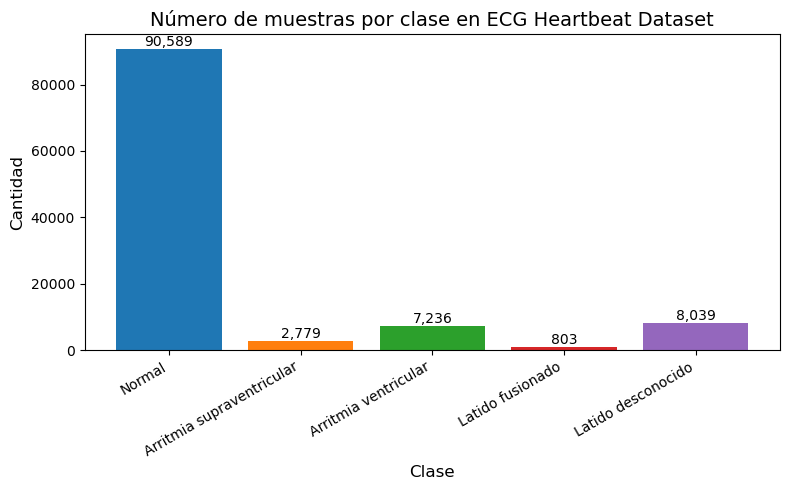

In [22]:
class_count = df.iloc[:, -1].value_counts().sort_index()

plot_class_distribution(
    x_labels=TARGET_NAMES,
    y_values=class_count.values,
    title="Número de muestras por clase en ECG Heartbeat Dataset"
)

Se observa una distribución fuertemente desbalanceada, donde la clase Normal representa más del 80% del total de los latidos. Las demás clases están subrepresentadas, siendo menores al 10 % del tamaño de la clase normal.
En particular, la clase Arritmia Supraventricular, que es una de las que mas nos importa detectar, tiene apenas un 3% de las muestras que posee la clase normal.

Como este es un problema de clasificación de datos médicos, nos parece que lo más grave es obtener falsos negativos (no detectar una arritmia). Con la distribución de clases así como viene, es muy probable que el modelo tienda a clasificar casos como "Normal" corriendo peligro de no detectar casos de arritmias.

Por eso, es fundamental tener en cuenta este desbalance durante el entrenamiento.

Algunas estrategias para mitigarlo son:
* Ponderación en la función de pérdida (class weights) para penalizar más los errores en clases con menos datos.
* Muestreo balanceado (WeightedRandomSampler) que aumente la frecuencia de las clases menos representadas durante el entrenamiento.
* Data augmentation específica para las clases minoritarias, generando nuevas muestras a partir de transformaciones leves de las señales originales.


## Visualización de los datos

Graficamos varios latidos de cada clase para ver como se vería en el ECG.

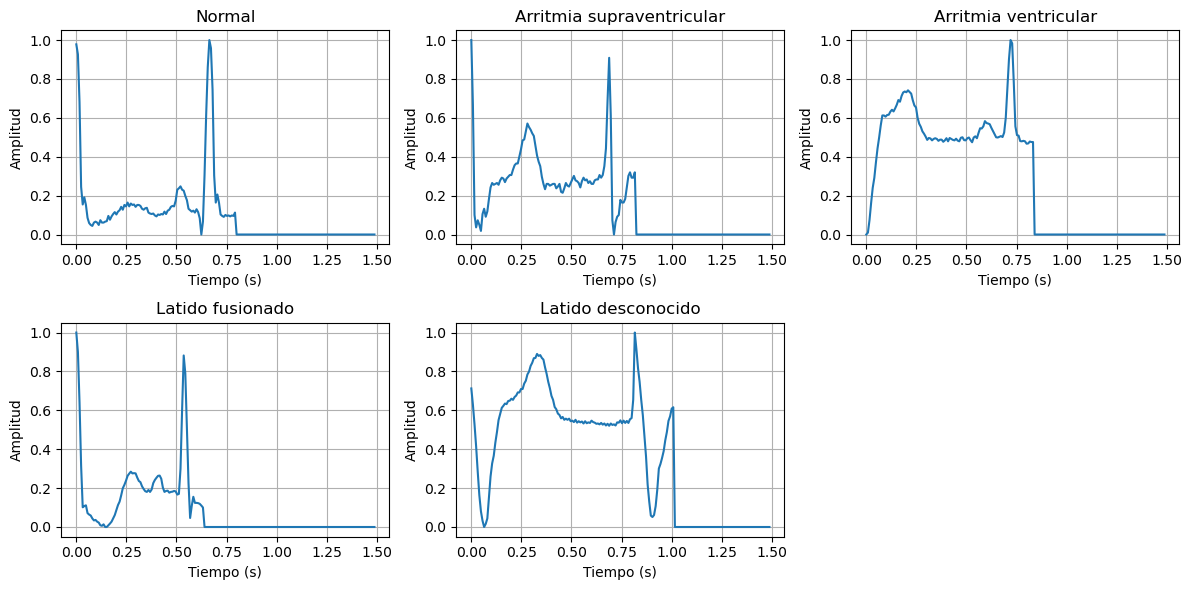

In [23]:
# Frecuencia de muestreo tomada de info en Kaggle
fs = 125

# Tomamos una fila de ejemplo por clase
clases = sorted(df_train.iloc[:, -1].unique())
ejemplos = {int(c): df_train[df_train.iloc[:, -1] == c].iloc[0] for c in clases}

n = len(clases)
cols = 3  # ajustá si querés
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows), squeeze=False)

for ax, c in zip(axes.flat, clases):
    fila = ejemplos[int(c)]
    x = fila.iloc[:-1].to_numpy(dtype=float)   # señal sin label
    N = len(x)
    t = np.arange(N) / fs

    ax.plot(t, x)
    ax.set_title(TARGET_NAMES[int(c)])
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Amplitud')
    ax.grid(True)

# Para que no aparezca la grafica que sobra
for i in range(n, rows*cols):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()


## Ceros al final de los datos

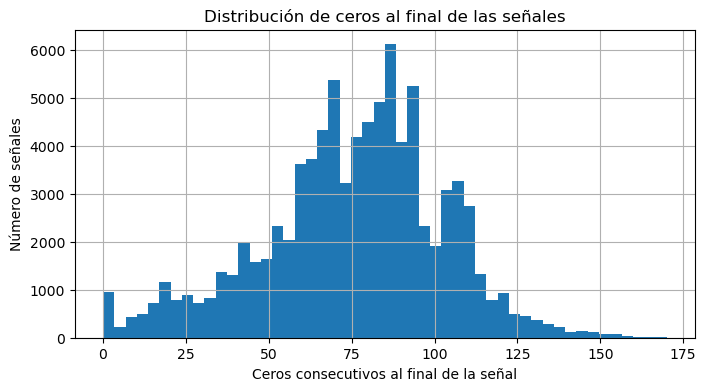

Promedio de ceros al final: 75.3
Máximo de ceros al final: 170


In [24]:
X = df_train.iloc[:, :-1].to_numpy(dtype=float) # todas las columnas menos la ultima

def ceros_al_final(arr):
    # Recorre desde el final hasta el primer valor != 0
    rev = arr[::-1]
    nz = np.argmax(rev != 0) # indice del primer elemento distinto de 0
    return len(arr) if nz == 0 and arr[-1] == 0 else nz

ceros_al_final = np.apply_along_axis(ceros_al_final, 1, X)

plt.figure(figsize=(8,4))
plt.hist(ceros_al_final, bins=50)
plt.xlabel("Ceros consecutivos al final de la señal")
plt.ylabel("Número de señales")
plt.title("Distribución de ceros al final de las señales")
plt.grid(True)
plt.show()

print(f"Promedio de ceros al final: {ceros_al_final.mean():.1f}")
print(f"Máximo de ceros al final: {ceros_al_final.max()}")


Hay una gran cantidad de datos que terminan con muchos ceros. Esto puede afectar el rendimiento de la RNN. Haremos pruebas con los datos así como están y también "recortando" la cantidad de ceros que aparece al final de cada fila.

# Preprocesamiento

En esta sección se prepararon los datos antes de entrenar los modelos.
El objetivo fue dejar las señales listas para que las redes recurrentes pudieran aprender de forma estable y captar correctamente los patrones de cada latido.

Las transformaciones aplicadas en esta etapa se implementaron de forma experimental, con el fin de evaluar si contribuían a mejorar el rendimiento y la capacidad de generalización del modelo.
A continuación se detallan las acciones probadas:

* Normalización: se aplicó z-score normalization para centrar y escalar las señales, garantizando que todas las características tuvieran media cero y desviación estándar uno. Esta técnica busca estabilizar los gradientes y acelerar la convergencia durante el entrenamiento.

* Data augmentation: se añadió ruido gaussiano con una probabilidad del 70 %, utilizando desviaciones aleatorias en el rango [0.005, 0.02]. El objetivo fue aumentar la variabilidad del conjunto de entrenamiento, simulando pequeñas perturbaciones en las señales reales y evaluando si esto ayudaba a reducir el sobreajuste.

* Verificación de calidad de datos: en la etapa de análisis se comprobó que el dataset no contenía valores nulos ni NaN, por lo que no fue necesario aplicar imputación ni limpieza adicional.

* Ajuste de formato para modelos secuenciales: se incorporó padding y packing para probar si adaptar las secuencias en función de los ceros al final de cada señal mejoraba el desempeño del modelo. Esto permite procesar correctamente secuencias de distintas longitudes y evitar que los ceros finales afecten el aprendizaje.

* Balanceo de clases: se implementó la función make_weighted_sampler para generar batches balanceados haciendo uso de WeightedRandomSampler, para poder aumentar la frecuencia de las clases minoritarias, con el objetivo de analizar si esta estrategia reducía el sesgo del modelo hacia la clase “Normal”.

In [25]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]   # Extraemos las etiquetas


X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]


print("X_train Shapes:", X_train.shape)
print("y_train Shapes:", y_train.shape)
print("X_test Shapes:", X_test.shape)
print("y_test Shapes:", y_test.shape)

X_train Shapes: (87554, 187)
y_train Shapes: (87554,)
X_test Shapes: (21892, 187)
y_test Shapes: (21892,)


Usamos train_test_split de sklearn para dividir el dataset en train y val, con stratify, porque las clases no están balanceadas.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (70043, 187) Val: (17511, 187)


## Normalizacion

Hacemos uso de z-score normalization

In [27]:
def zscore_normalization(x, eps = 1e-8):
    mean = x.mean()
    std = x.std()
    return (x - mean) / (std + eps)

## Data Augmentation

In [28]:
def add_gaussian_noise(x, sigma_range=(0.005, 0.02), p=0.7):
    if np.random.rand() < p:
        sigma = np.random.uniform(*sigma_range)
        x = x + np.random.normal(0.0, sigma, size=x.shape).astype(x.dtype)
    return x

##  Balanceo de clases (WeightedRandomSampler)

In [ ]:
def get_counts(y):
    y = np.asarray(y)
    counts = Counter(y)
    total = len(y)
    return counts, total


def make_weighted_sampler(y, n_classes=5):
    counts, total = get_counts(y)
    class_weight = {c: total / (n_classes * counts.get(c, 1)) for c in range(n_classes)}
    sample_weights = np.array([class_weight[int(lbl)] for lbl in y], dtype=np.float32)
    weights_tensor = torch.from_numpy(sample_weights)
    return WeightedRandomSampler(weights=weights_tensor, num_samples=len(weights_tensor), replacement=True)

[N, A] , [1/100, 1]

## Transform function
Funcion creada para aplicar las funciones anteriores segun flags

In [29]:
def train_transform_np(X, use_zscore=False, use_augmentation=False) -> np.ndarray:
    x = X.copy()
    if use_zscore:
        x = zscore_normalization(x)
    if use_augmentation:
        x = add_gaussian_noise(x)
    return x

def eval_transform_np(X, use_zscore=False):
    if use_zscore:
        X = zscore_normalization(X)
    return X

# Dataset y DataLoader

Una vez definidas las funciones de preprocesamiento, se creó la clase personalizada ECGDataset, encargada de preparar las señales de electrocardiograma (ECG) y sus etiquetas para ser utilizadas por PyTorch.
Cada muestra representa un latido cardíaco de 187 puntos, con una etiqueta asociada que indica el tipo de latido.

El dataset convierte los datos en tensores y aplica, cuando corresponde, las transformaciones definidas en el preprocesamiento, como normalización o data augmentation.

También se implementó la función get_dataloaders, encargada de generar los DataLoader para entrenamiento, validación y prueba.
Al crear los mini-batches, esta función permite aplicar diferentes estrategias de carga, como WeightedRandomSampler y packing, para experimentar con balanceo de clases y manejo de secuencias de distinta longitud.

## Dataset

In [ ]:
class ECGDataset(Dataset):
    def __init__(self, df_features, df_target, transform=None, target_transform=None):
        self.x_df = np.asarray(df_features, dtype=np.float32)
        self.y_df = np.asarray(df_target, dtype=np.int64)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):  # tamaño del dataset
        return len(self.x_df)

    def __getitem__(self, idx):
        x = self.x_df[idx]
        y = self.y_df[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
       
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # [187, 1]
        y = torch.tensor(y, dtype=torch.long)  # la cross-entropy loss necesita que el target sea long

        return x, y

## Dataloader

In [ ]:
# Prepara las secuencias de un batch aplicando pack_padded_sequence,
# para que el modelo procese solo la parte útil de cada señal y omita los ceros al final.
def collate_pack(batch):
    # batch: [(X[T,D], y)]
    X = torch.stack([b[0] for b in batch], dim=0)            # [B,T,D]
    y = torch.stack([b[1] for b in batch], dim=0)            # [B]
    lens = (X.abs().sum(dim=-1) > 0).sum(dim=-1)             # [B] pasos no-cero
    return X, lens, y

In [ ]:
def get_dataloaders(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    train_transf=None, val_transf=None,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
    use_sampler = True,
    packing=False
    # pin_memory: bool = True,
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - X_train: features del dataset
    - y_train: labels del dataset
    - train_transf: transformaciones para el dataset de entrenamiento
    - val_transf: transformaciones para el dataset de val
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    train_dataset = ECGDataset(X_train, y_train, train_transf)
    val_dataset = ECGDataset(X_val, y_val, val_transf)
    test_dataset = ECGDataset(X_test, y_test, val_transf)

    # si usamos use_sampler entonces el batch se balancea por muestreo
    sampler = make_weighted_sampler(y_train, n_classes=5) if use_sampler else None
    shuffle = not use_sampler

    if packing:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=num_workers, collate_fn=collate_pack
            )

        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_pack
        )

        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_pack
        )
    else:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=num_workers
        )

        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
        )
        
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
        )

    return train_loader, val_loader, test_loader

## Testing dataloaders return shapes

In [39]:
train_loader, val_loader, test_loader = get_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, use_sampler=False, for_cnn=True
)

print(f"Train loader: {train_loader}")
print(f"Val loader: {val_loader}")
print(f"Test loader: {test_loader}")

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x33187f360>
Val loader: <torch.utils.data.dataloader.DataLoader object at 0x33187ed70>
Test loader: <torch.utils.data.dataloader.DataLoader object at 0x331872c30>
torch.Size([256, 1, 187]) torch.Size([256])


# Ver transfer learning entre nuestras pruebas

# Models

## 1. SIMPLE RNN

In [40]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, dropout=0.3):
        super(SimpleRNN, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_dim, hidden_dim * 2)
        self.out = nn.Linear(hidden_dim * 2, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        _, hidden = self.rnn(x)                # out: [batch, seq_len, hidden_dim]
        hidden = hidden[-1]                    # último hidden state: [batch, hidden_dim]
        x = self.relu(self.fc(hidden))         # [batch, hidden_dim*2]
        x = self.drop(x)
        # no necesito usar softmax porque CrossEntropyLoss ya lo aplica
        x = self.out(x)                        # [batch, num_classes]
        return x


### 1.1. Testing RNN

In [41]:
rnn_model = SimpleRNN(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

In [42]:
train_loader, val_loader, test_loader = get_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, use_sampler=False
)

In [43]:
xb, yb = next(iter(train_loader))
xb, yb = xb.to(DEVICE), yb.to(DEVICE)

logits = rnn_model(xb)
print("Logits shape:", logits.shape)  # [batch_size, num_classes]
loss = criterion(logits, yb)
print("Loss:", loss.item())

Logits shape: torch.Size([256, 5])
Loss: 1.6281906366348267


### 1.2 SIMPLE RNN con packing sequence

In [44]:
class SimpleRNN_packing(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, dropout=0.3):
        super(SimpleRNN_packing, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_dim, hidden_dim * 2)
        self.out = nn.Linear(hidden_dim * 2, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, lens):
        # x: [B,T,D], lens: [B]
        # empaquetar
        packed = pack_padded_sequence(x, lengths=lens.cpu(), batch_first=True, enforce_sorted=False)
        _, h_n = self.rnn(packed)  # [layers*dirs, B, H]

        if self.rnn.bidirectional:
            h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)  # [B, 2H]
        else:
            h_last = h_n[-1]  # [B, H]

        z = self.relu(self.fc(h_last))   # 64/2H -> 128
        z = self.drop(z)
        logits = self.out(z)             # 128 -> C
        return logits



## 2. GRU

Probamos [GRU](https://d2l.ai/chapter_recurrent-modern/gru.html) en una RNN con dos gates extras (reset y update) para controlar cómo fluye la información entre pasos temporales.

Se agrega la flag bidirectional, que en caso de estar activa, PyTorch crea dos GRUs internas, una que procesa la secuencia hacia adelante (normal) y otra que procesa la secuencia hacia atrás. Esto tiene como ventaja que cada punto de la secuencia tiene información tanto del pasado como del futuro.

In [45]:
class GRU(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, dropout=0.3, bidirectional=False):
        super(GRU, self).__init__()
        self.bidirectional = bidirectional
        self.n_layers = n_layers
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        # Si es bidireccional, duplicamos el tamaño del hidden state
        factor = 2 if bidirectional else 1
        self.fc= nn.Linear(hidden_dim * factor, hidden_dim * 2)
        self.our = nn.Linear(hidden_dim * 2, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        _, hidden = self.gru(x)       # hidden: [n_layers * num_directions, batch, hidden_dim]
        hidden = hidden[-1] if not self.bidirectional else torch.cat((hidden[-2], hidden[-1]), dim=1)
        x = self.relu(self.fc(hidden))
        x = self.drop(x)
        x = self.our(x)
        return x  # [batch, num_classes]


### GRU con packing sequence

In [46]:
class GRU_packing(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2,
                 num_classes=5, dropout=0.3, bidirectional=False):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        factor = 2 if bidirectional else 1
        self.fc  = nn.Linear(hidden_dim * factor, hidden_dim * 2)
        self.our = nn.Linear(hidden_dim * 2, num_classes)  # mantengo tu nombre
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, h0=None):
        B = x.batch_sizes[0].item() if isinstance(x, torch.nn.utils.rnn.PackedSequence) else x.size(0)
        num_layers     = self.gru.num_layers
        num_directions = 2 if self.gru.bidirectional else 1
        hidden_size    = self.gru.hidden_size

        if h0 is None:
            h0 = torch.zeros(num_layers * num_directions, B, hidden_size, device=(x.data.device if isinstance(x, torch.nn.utils.rnn.PackedSequence) else x.device))

        _, hidden = self.gru(x, h0)  # hidden: (num_layers*num_directions, B, H)

        # índice del último layer dentro de `hidden`
        start = (num_layers - 1) * num_directions
        if self.gru.bidirectional:
            # últimas dos direcciones del último layer: (2, B, H) -> (B, 2H)
            last = hidden[start:start+num_directions].transpose(0, 1).reshape(B, -1)
        else:
            last = hidden[start]  # (B, H)

        x = self.relu(self.fc(last))
        x = self.drop(x)
        x = self.our(x)
        return x  # (B, num_classes)


## 3. LSTM

La [LSTM (Long Short-Term Memory)](https://d2l.ai/chapter_recurrent-neural-networks/index.html) es un tipo de red neuronal recurrente diseñada para aprender dependencias a largo plazo en secuencias.
A diferencia de una RNN simple, incluye puertas de entrada, olvido y salida que controlan qué información se mantiene o se descarta en cada paso temporal.
Esto permite que la LSTM recuerde patrones importantes durante más tiempo y evite el problema del desvanecimiento del gradiente, siendo especialmente útil para analizar señales como los ECG.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, dropout=0.3, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

    def forward(self, x, h0=None, c0=None):
        B = x.size(0)
        num_layers     = self.lstm.num_layers
        num_directions = 2 if self.lstm.bidirectional else 1
        hidden_size    = self.lstm.hidden_size

        if h0 is None or c0 is None:
            h0 = torch.zeros(num_layers * num_directions, B, hidden_size, device=x.device)
            c0 = torch.zeros(num_layers * num_directions, B, hidden_size, device=x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        # hn: (num_layers*num_directions, B, H)

        if self.lstm.bidirectional:
            # última capa → dos direcciones (2, B, H) → (B, 2H)
            last = hn[-num_directions:, :, :].transpose(0, 1).reshape(B, -1)
        else:
            last = hn[-1]  # (B, H)

        logits = self.fc(last)
        return logits


### LSTM con packing sequence

In [48]:
from torch.nn.utils.rnn import pack_padded_sequence, PackedSequence

class LSTMModel_packing(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, n_layers=2, num_classes=5,
                 dropout=0.3, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

    def forward(self, x, lengths=None, h0=None, c0=None):
        """
        x: (B, T, D) o PackedSequence
        lengths: tensor (B,) con longitudes reales (sin padding)
        """
        # tamaño de batch
        B = x.batch_sizes[0].item() if isinstance(x, PackedSequence) else x.size(0)

        num_layers     = self.lstm.num_layers
        num_directions = 2 if self.lstm.bidirectional else 1
        hidden_size    = self.lstm.hidden_size

        # estados iniciales
        device = x.data.device if isinstance(x, PackedSequence) else x.device
        if h0 is None or c0 is None:
            h0 = torch.zeros(num_layers * num_directions, B, hidden_size, device=device)
            c0 = torch.zeros_like(h0)

        # packing
        if isinstance(x, PackedSequence):
            packed = x
        else:
            assert lengths is not None, "Debes pasar 'lengths' si x no es PackedSequence."
            packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # LSTM
        _, (hn, cn) = self.lstm(packed, (h0, c0))

        # salida final
        if self.lstm.bidirectional:
            last = hn[-num_directions:, :, :].transpose(0, 1).reshape(B, -1)
        else:
            last = hn[-1]

        logits = self.fc(last)
        return logits


# Training

En esta sección se describen las configuraciones y estrategias utilizadas para entrenar los distintos modelos (RNN, GRU y LSTM), así como los parámetros y técnicas de regularización aplicadas durante el proceso.

### Funciones Auxiliares

In [ ]:
# Calcula los pesos de cada clase en función de su frecuencia en el dataset.
# Las clases con menos muestras obtienen un peso mayor, para que la función de pérdida
# las considere más durante el entrenamiento y se reduzca el sesgo hacia las clases mayoritarias.
def compute_class_weights(y, n_classes=5):
    counts, total = get_counts(y)
    weights = np.array([total / (n_classes * counts.get(c, 1)) for c in range(n_classes)], dtype=np.float32)
    weights = weights / weights.mean()  # opcional: normalizar
    return torch.tensor(weights, dtype=torch.float32)

# Ejemplo:
class_weights = compute_class_weights(y_train, n_classes=5)
print(f"Class weights: {class_weights}\n")
print(f"Cantidad por clase: \n{get_counts(y_train)}")

Class weights: tensor([0.0293, 0.9567, 0.3674, 3.3159, 0.3306])

Cantidad por clase: 
(Counter({np.float64(0.0): 57977, np.float64(4.0): 5145, np.float64(2.0): 4630, np.float64(1.0): 1778, np.float64(3.0): 513}), 70043)


In [122]:
def run_rnn_model(
    use_zscore=False,
    use_augmentation=False,
    use_sampler=False,
    use_class_weights=False,
    early_stopping=False,
    model='rnn',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    packing=False,
    log=print_log,
    epochs=EPOCHS,
    optimizer=None,
    criterion=None,
):

    train_transf = lambda x: train_transform_np(x, use_zscore=use_zscore, use_augmentation=use_augmentation)
    val_transf   = lambda x: eval_transform_np(x,  use_zscore=use_zscore)

    train_loader, val_loader, test_loader = get_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        train_transf=train_transf,
        val_transf=val_transf,
        use_sampler=use_sampler,  # True => balancea batches por muestreo
        packing=packing
    )

    print(f"Running: {model}")
    if model == 'rnn':
        model = SimpleRNN(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) if optimizer is None else optimizer

    # si usamos use_class_weights entonces se balancea por class weights
    if criterion is None:
        if use_class_weights:
            class_weights = compute_class_weights(y_train, n_classes=5).to(DEVICE)
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)
        else:
            criterion = nn.CrossEntropyLoss().to(DEVICE)


    # Chequeo rápido
    #xb, yb = next(iter(train_loader))
    #print("Batch:", xb.shape, yb.shape)  # esperado: [B,187,1]  [B]

    if packing:
        epoch_train_errors, epoch_val_errors = train_with_packing(
            model,
            optimizer,
            criterion,
            train_loader,
            val_loader,
            DEVICE,
            do_early_stopping=early_stopping,
            patience=12,
            epochs=epochs,
            log_fn=log,
            log_every=20,
        )
    else:
        epoch_train_errors, epoch_val_errors = train(
            model,
            optimizer,
            criterion,
            train_loader,
            val_loader,
            DEVICE,
            do_early_stopping=early_stopping,
            patience=12,
            epochs=epochs,
            log_fn=log,
            log_every=20,
        )

    plot_training(epoch_train_errors, epoch_val_errors)

    model_classification_report(
        model, test_loader, DEVICE, nclasses, packing=packing, do_confusion_matrix=True
    )
    return epoch_train_errors, epoch_val_errors


## Training RNN

### RNN simple

Prueba sin abordar desbalance de clases y con datos completos.

Running: rnn
Epoch: 020/120 | Train Loss: 0.63361 | Val Loss: 0.62892
Epoch: 040/120 | Train Loss: 0.63369 | Val Loss: 0.62816
Epoch: 060/120 | Train Loss: 0.65812 | Val Loss: 0.65873
Epoch: 080/120 | Train Loss: 0.65789 | Val Loss: 0.65787
Epoch: 100/120 | Train Loss: 0.64691 | Val Loss: 0.64433
Epoch: 120/120 | Train Loss: 0.56051 | Val Loss: 0.54776


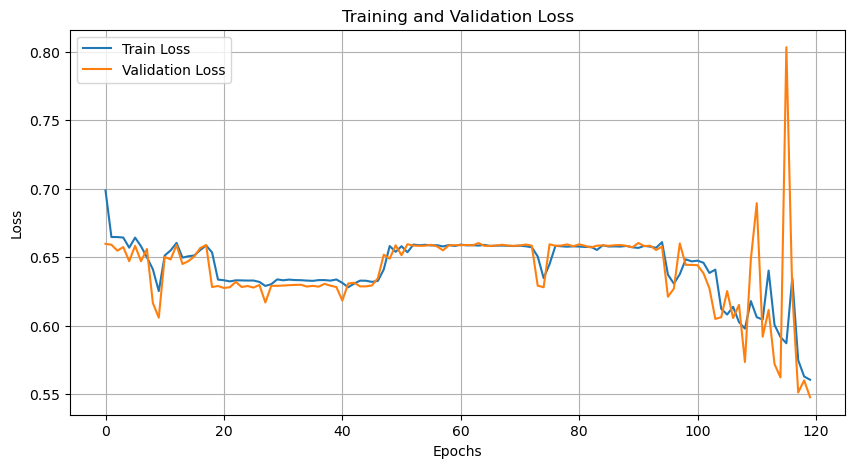

Accuracy: 0.8440

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91     18118
           1       0.00      0.00      0.00       556
           2       0.66      0.20      0.30      1448
           3       0.00      0.00      0.00       162
           4       0.55      0.38      0.45      1608

    accuracy                           0.84     21892
   macro avg       0.42      0.31      0.33     21892
weighted avg       0.80      0.84      0.81     21892



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

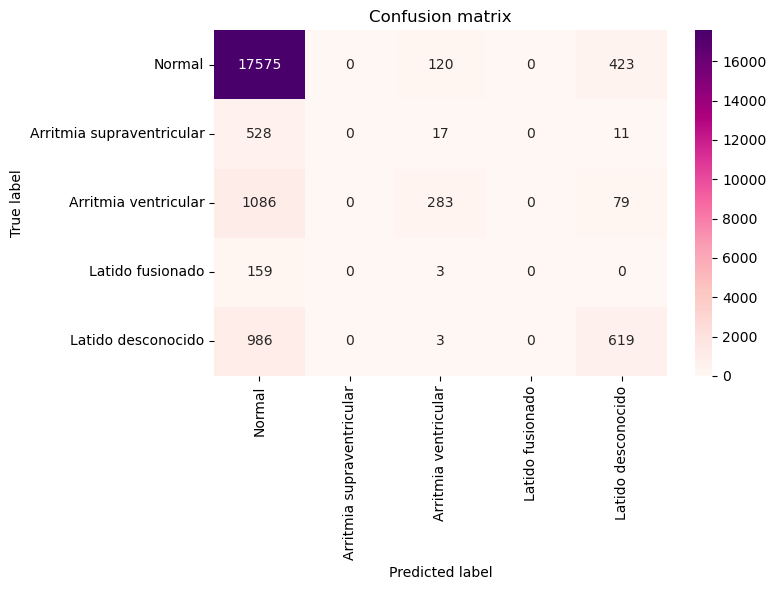

In [60]:
rnn_1_train_errors, rnn_1_val_errors = run_rnn_model()

### RNN simple + z-score

Running: rnn
Epoch: 020/120 | Train Loss: 0.55488 | Val Loss: 0.55929
Epoch: 040/120 | Train Loss: 0.55569 | Val Loss: 0.55676
Epoch: 060/120 | Train Loss: 0.61506 | Val Loss: 0.60110
Epoch: 080/120 | Train Loss: 0.60153 | Val Loss: 0.57925
Epoch: 100/120 | Train Loss: 0.50008 | Val Loss: 0.45075
Epoch: 120/120 | Train Loss: 0.52869 | Val Loss: 0.50883


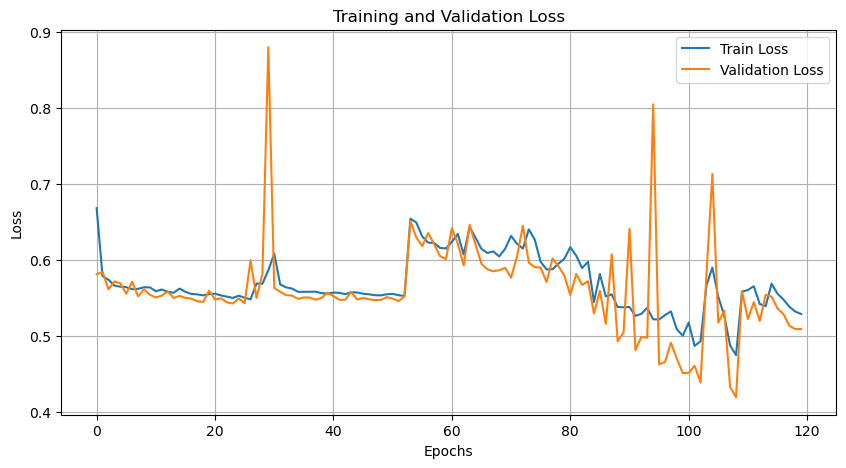

Accuracy: 0.8473

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92     18118
           1       0.64      0.05      0.10       556
           2       0.64      0.26      0.37      1448
           3       0.00      0.00      0.00       162
           4       0.88      0.14      0.24      1608

    accuracy                           0.85     21892
   macro avg       0.60      0.29      0.32     21892
weighted avg       0.83      0.85      0.80     21892



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

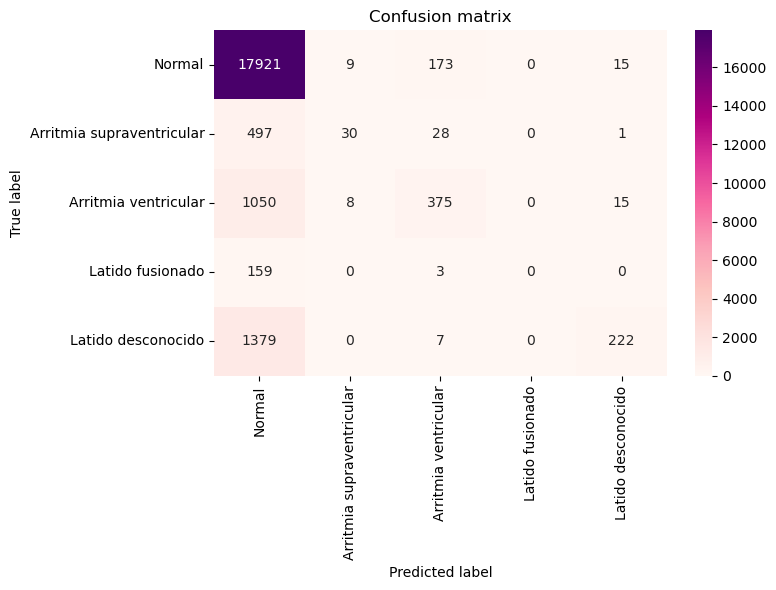

In [61]:
rnn_1_train_errors, rnn_1_val_errors = run_rnn_model(use_zscore=True)

### RNN simple + z-score + augmentation

Running: rnn
Epoch: 020/120 | Train Loss: 0.58435 | Val Loss: 0.53836
Epoch: 040/120 | Train Loss: 0.33813 | Val Loss: 0.31044
Epoch: 060/120 | Train Loss: 0.33734 | Val Loss: 0.32965
Epoch: 080/120 | Train Loss: 0.52915 | Val Loss: 0.51451
Epoch: 100/120 | Train Loss: 0.56467 | Val Loss: 0.53895
Epoch: 120/120 | Train Loss: 0.52579 | Val Loss: 0.51498


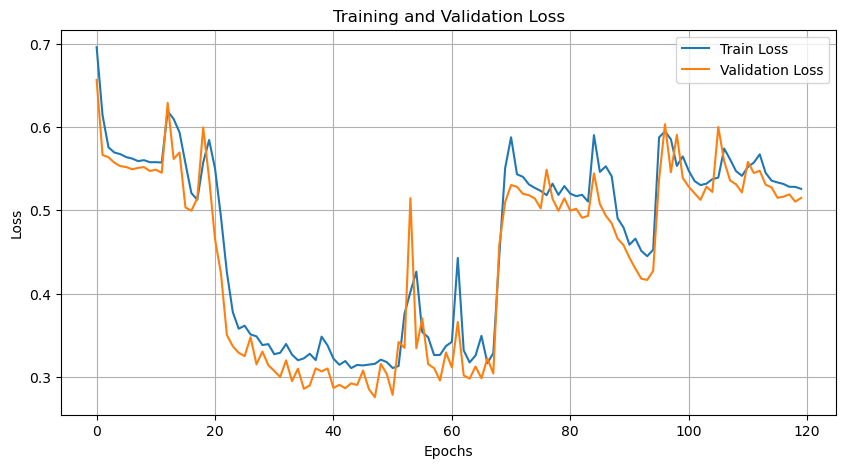

Accuracy: 0.8382

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     18118
           1       0.00      0.00      0.00       556
           2       0.66      0.23      0.34      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.84     21892
   macro avg       0.30      0.25      0.25     21892
weighted avg       0.74      0.84      0.78     21892



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

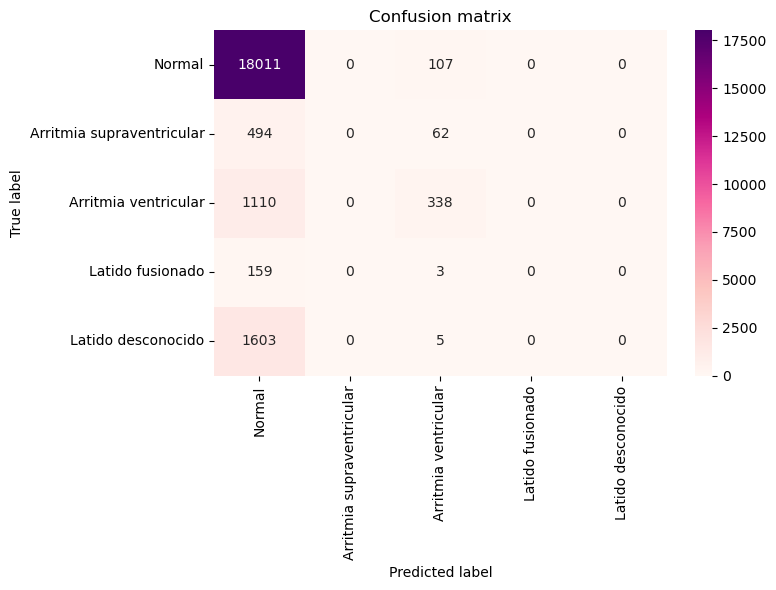

In [62]:
rnn_5_train_errors, rnn_5_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True)

### Obserbaciones RNN simple

En los entrenamientos realizados con la RNN simple se observó un rendimiento similar en los tres casos, con buena precisión en la clase “Normal” pero un desempeño muy bajo en las clases minoritarias.
La matriz de confusión muestra muchos valores en cero, lo que indica que las clases menos representadas prácticamente no se aprenden.

La normalización z-score ayudó a que el entrenamiento fuera más estable y mejoró levemente las métricas de precisión, recall y f1-score, sin afectar la accuracy global.
Por otro lado, el uso de data augmentation generó un pequeña desmejoras en las métricas.

A nivel general, los resultados muestran que el principal desafío sigue siendo el desbalance de clases, generando clases que no logren ser predecidas.

### RNN + use_class_weights
Probamos modelo actualizando los pesos segun distribucion de clases.

Running: rnn
Epoch: 020/120 | Train Loss: 1.53061 | Val Loss: 1.52571
Epoch: 040/120 | Train Loss: 1.58112 | Val Loss: 1.56714
Epoch: 060/120 | Train Loss: 1.50302 | Val Loss: 1.47885
Epoch: 080/120 | Train Loss: 1.50566 | Val Loss: 1.49149
Epoch: 100/120 | Train Loss: 1.49027 | Val Loss: 1.47260
Epoch: 120/120 | Train Loss: 1.60885 | Val Loss: 1.60888


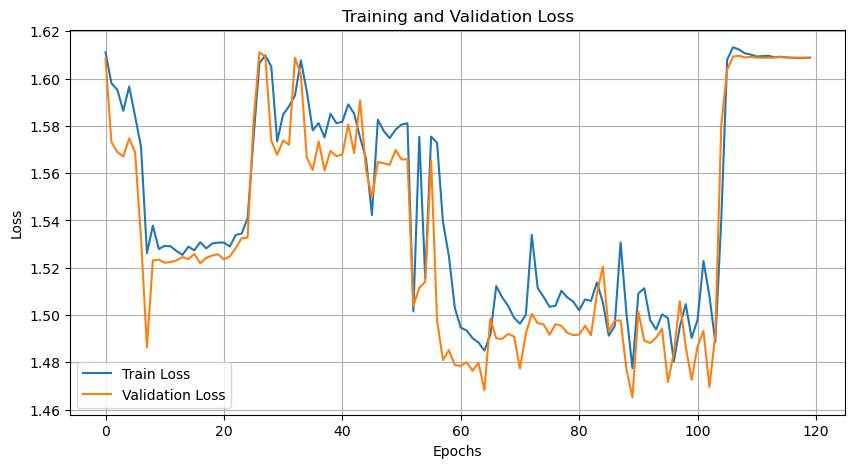

Accuracy: 0.8276

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91     18118
           1       0.00      0.00      0.00       556
           2       0.00      0.00      0.00      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.83     21892
   macro avg       0.17      0.20      0.18     21892
weighted avg       0.68      0.83      0.75     21892



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

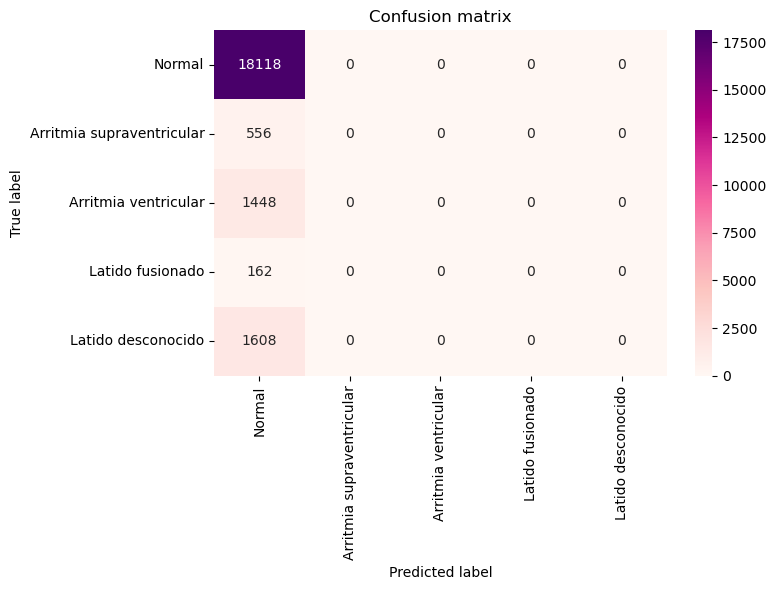

In [63]:
rnn_2_train_errors, rnn_2_val_errors = run_rnn_model(use_class_weights=True)


#### Observaciones
Vemos que el modelo sigue sin poder clasificar clases que no sean la "Normal". Las clases están tan desbalanceadas, que con los class weights no logramos ayudar al modelo.

### RNN + use_class_weights + use_sampler


Running: rnn
Epoch: 020/120 | Train Loss: 0.92984 | Val Loss: 2.48112
Epoch: 040/120 | Train Loss: 0.99511 | Val Loss: 2.47576
Epoch: 060/120 | Train Loss: 0.97316 | Val Loss: 2.53423
Epoch: 080/120 | Train Loss: 0.98430 | Val Loss: 2.55733
Epoch: 100/120 | Train Loss: 0.98993 | Val Loss: 2.54436
Epoch: 120/120 | Train Loss: 0.99531 | Val Loss: 2.54732


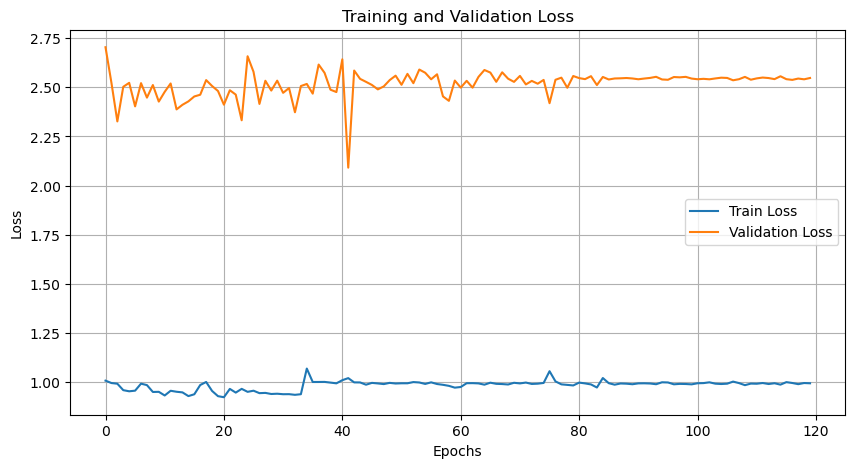

Accuracy: 0.0074

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     18118
           1       0.00      0.00      0.00       556
           2       0.00      0.00      0.00      1448
           3       0.01      1.00      0.01       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.01     21892
   macro avg       0.00      0.20      0.00     21892
weighted avg       0.00      0.01      0.00     21892



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

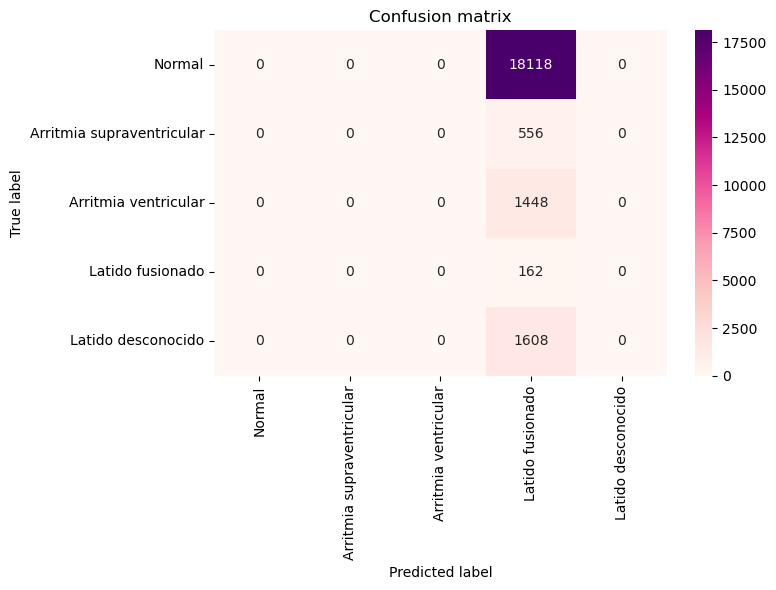

In [64]:
rnn_3_train_errors, rnn_3_val_errors = run_rnn_model(use_sampler=True, use_class_weights=True)

Con ambas opciones habilitadas parecería que corregimos de más. Probamos usando solamente el sampler:

### RNN + use_sampler

Running: rnn
Epoch: 020/120 | Train Loss: 1.57241 | Val Loss: 1.56491
Epoch: 040/120 | Train Loss: 1.57691 | Val Loss: 1.58790
Epoch: 060/120 | Train Loss: 1.57625 | Val Loss: 1.58387
Epoch: 080/120 | Train Loss: 1.18541 | Val Loss: 1.39407
Epoch: 100/120 | Train Loss: 1.13853 | Val Loss: 1.31016
Epoch: 120/120 | Train Loss: 1.43602 | Val Loss: 1.48859


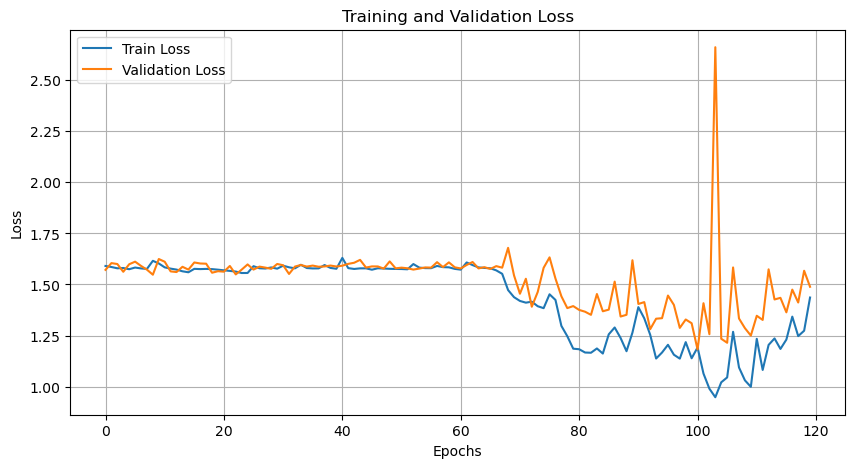

Accuracy: 0.0269

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     18118
           1       0.00      0.00      0.00       556
           2       0.35      0.30      0.32      1448
           3       0.01      0.98      0.02       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.03     21892
   macro avg       0.07      0.26      0.07     21892
weighted avg       0.02      0.03      0.02     21892



/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

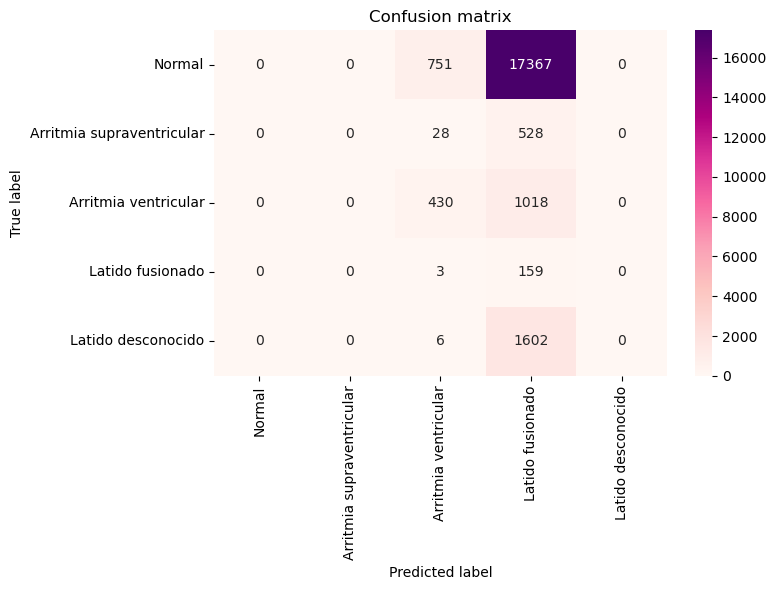

In [65]:
rnn_4_train_errors, rnn_4_val_errors = run_rnn_model(use_sampler=True)

Seguimos teniendo el mismo problema...

### RNN + use_sampler + transform (z-score y augmentation)

Running: rnn
Epoch: 020/120 | Train Loss: 0.95118 | Val Loss: 1.23912
Epoch: 040/120 | Train Loss: 0.89001 | Val Loss: 1.13289
Epoch: 060/120 | Train Loss: 0.96228 | Val Loss: 1.12999
Epoch: 080/120 | Train Loss: 0.76530 | Val Loss: 0.93282
Epoch: 100/120 | Train Loss: 0.59941 | Val Loss: 1.07353
Epoch: 120/120 | Train Loss: 0.53798 | Val Loss: 0.58503


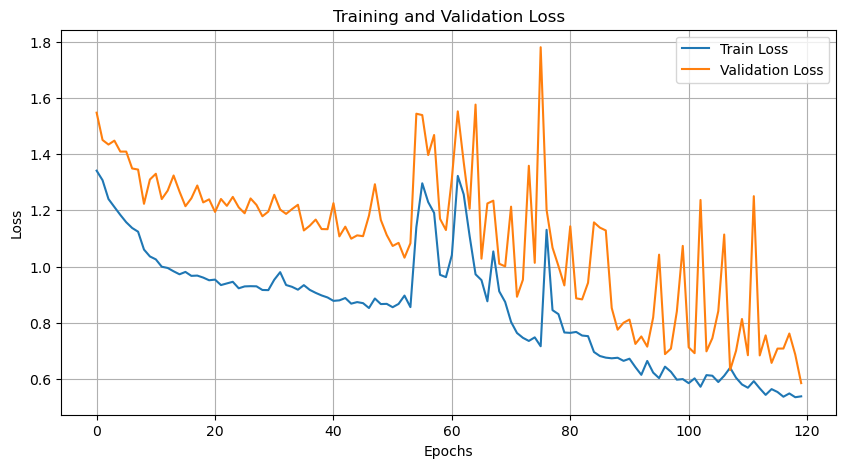

Accuracy: 0.8323

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.83      0.90     18118
           1       0.19      0.69      0.30       556
           2       0.58      0.83      0.68      1448
           3       0.18      0.88      0.29       162
           4       0.93      0.89      0.91      1608

    accuracy                           0.83     21892
   macro avg       0.57      0.82      0.62     21892
weighted avg       0.92      0.83      0.86     21892



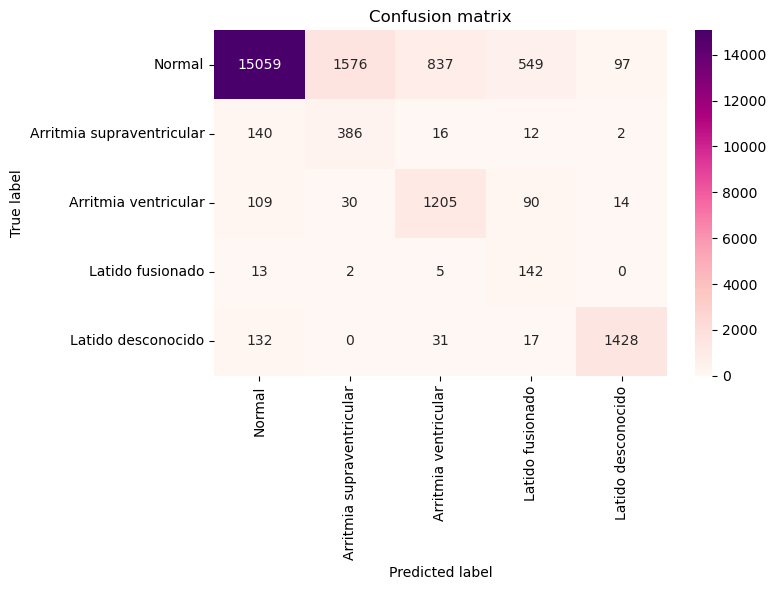

In [66]:
rnn_5_train_errors, rnn_5_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, use_sampler=True)

### RNN con menos ceros
 Modificando cantidad de ceros manualmente

Probamos este mismo ejemplo pero deshaciendonos de la mayoria de los ceros al final de cada fila:

Running: rnn
Epoch: 020/120 | Train Loss: 0.97771 | Val Loss: 1.14650
Epoch: 040/120 | Train Loss: 0.76926 | Val Loss: 1.09955
Epoch: 060/120 | Train Loss: 0.93969 | Val Loss: 1.17502
Epoch: 080/120 | Train Loss: 1.00315 | Val Loss: 1.08086
Epoch: 100/120 | Train Loss: 0.64201 | Val Loss: 0.88655
Epoch: 120/120 | Train Loss: 1.01662 | Val Loss: 1.26677


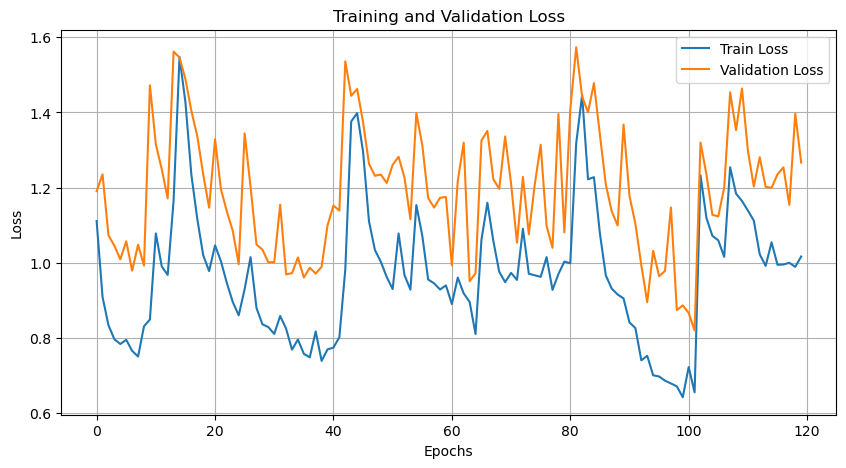

Accuracy: 0.4307

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.95      0.38      0.54     18118
           1       0.09      0.54      0.15       556
           2       0.18      0.47      0.26      1448
           3       0.03      0.88      0.05       162
           4       0.59      0.88      0.70      1608

    accuracy                           0.43     21892
   macro avg       0.37      0.63      0.34     21892
weighted avg       0.84      0.43      0.52     21892



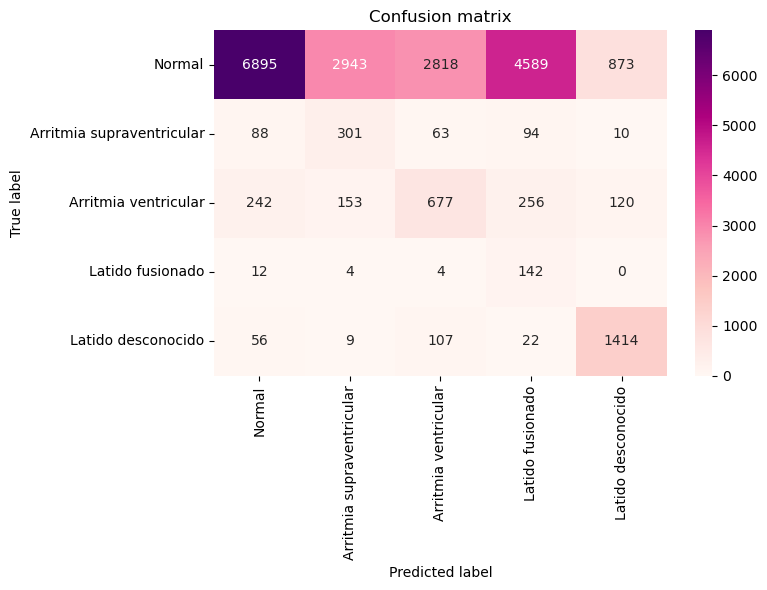

In [67]:
X_train_ceros = df_train.iloc[:, :-1-75]  # todas menos el target y las últimas 75 features
y_train_ceros = df_train.iloc[:, -1]

X_test_ceros = df_test.iloc[:, :-1-75]
y_test_ceros = df_test.iloc[:, -1]

X_train_ceros, X_val_ceros, y_train_ceros, y_val_ceros = train_test_split(
    X_train_ceros, y_train_ceros, test_size=0.2, random_state=SEED, stratify=y_train_ceros
)

rnn_6_train_errors, rnn_6_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, use_sampler=True,
                                                     X_train=X_train_ceros, y_train=y_train_ceros,
                                                     X_val=X_val_ceros, y_val=y_val_ceros,
                                                     X_test=X_test_ceros, y_test=y_test_ceros)

Empeoró el resultado. Pero puede que sea porque al tomar 75 como promedio de cantidad de ceros, hay datos en los que borramos informacion util.

Probamos con :

https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html

https://www.geeksforgeeks.org/deep-learning/how-do-you-handle-sequence-padding-and-packing-in-pytorch-for-rnns/

### RNN + packing

Modificando cantidad de ceros usando padding and packing de pytorch

Running: SimpleRNN_packing(
  (drop): Dropout(p=0.3, inplace=False)
  (rnn): RNN(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU(inplace=True)
)
Epoch: 020/120 | Train Loss: 0.95658 | Val Loss: 1.15179
Epoch: 040/120 | Train Loss: 1.32760 | Val Loss: 1.49816
Epoch: 060/120 | Train Loss: 1.28888 | Val Loss: 1.47160
Epoch: 080/120 | Train Loss: 1.26313 | Val Loss: 1.42192
Epoch: 100/120 | Train Loss: 1.19580 | Val Loss: 1.36422
Epoch: 120/120 | Train Loss: 1.22604 | Val Loss: 1.40806


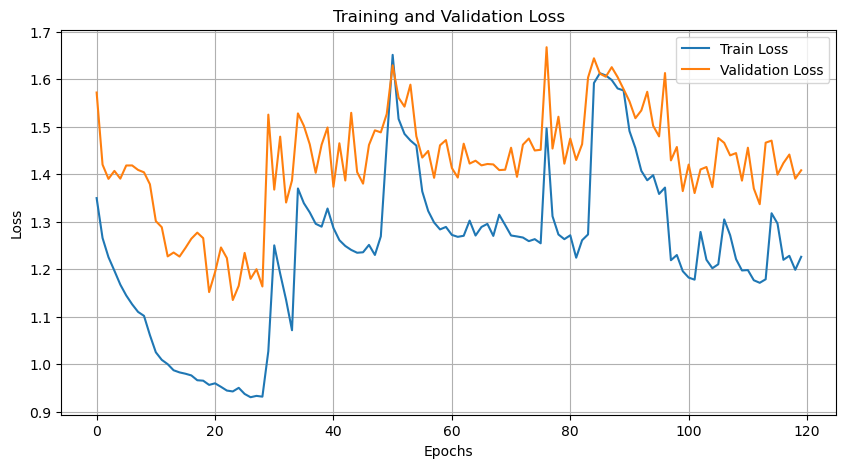

Accuracy: 0.3335

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.28      0.43     18118
           1       0.07      0.16      0.09       556
           2       0.22      0.45      0.29      1448
           3       0.02      0.83      0.04       162
           4       0.24      0.81      0.37      1608

    accuracy                           0.33     21892
   macro avg       0.29      0.51      0.25     21892
weighted avg       0.80      0.33      0.41     21892



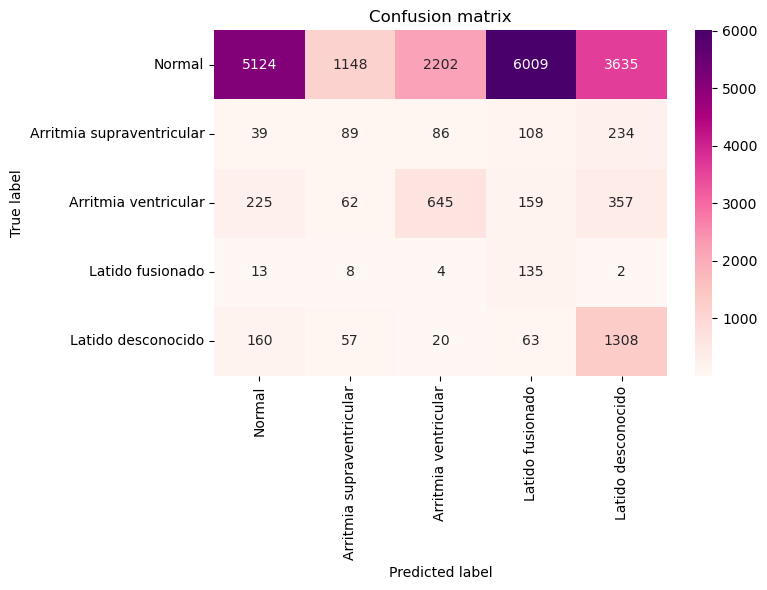

In [58]:
model_7 = SimpleRNN_packing(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5).to(DEVICE)
rnn_7_train_errors, rnn_7_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, use_sampler=True,
                                                     packing=True, model=model_7)

## Training GRU



### GRU

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.09118 | Val Loss: 0.07868
Epoch: 040/120 | Train Loss: 0.05536 | Val Loss: 0.06501
Epoch: 060/120 | Train Loss: 0.04098 | Val Loss: 0.06132
Epoch: 080/120 | Train Loss: 0.03326 | Val Loss: 0.05909
Epoch: 100/120 | Train Loss: 0.02781 | Val Loss: 0.06490
Epoch: 120/120 | Train Loss: 0.02244 | Val Loss: 0.06959


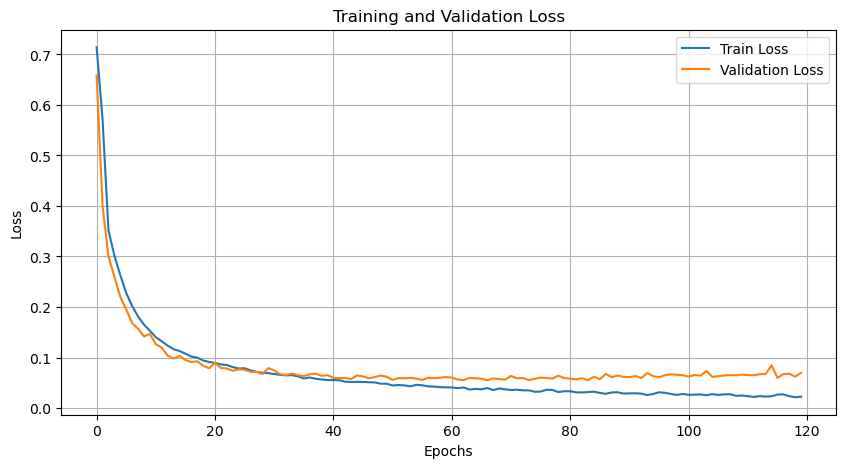

Accuracy: 0.9818

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.85      0.81      0.83       556
           2       0.93      0.95      0.94      1448
           3       0.77      0.77      0.77       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.91      0.90      0.90     21892
weighted avg       0.98      0.98      0.98     21892



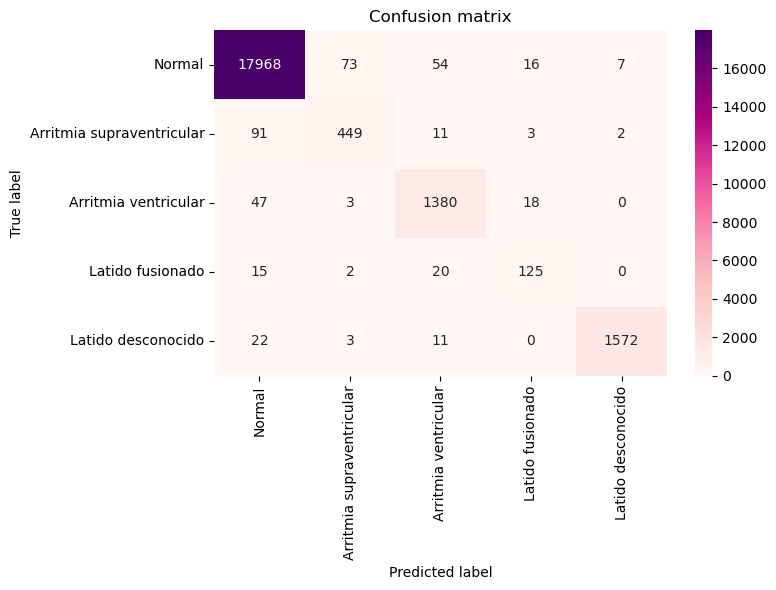

In [ ]:
model_gru_0 = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=False).to(DEVICE)
gru_0_train_errors, qru_0_val_errors = run_rnn_model(model=model_gru_0)

### GRU + z-score

In [ ]:
model_gru_z = GRU().to(DEVICE)
gru_z_train_errors, gru_z_val_errors = run_rnn_model(use_zscore=True, model=model_gru_z)

### GRU + use_sampler

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020 | Train Loss: 0.33711 | Val Loss: 0.48550
Epoch: 040 | Train Loss: 0.16361 | Val Loss: 0.33832
Epoch: 060 | Train Loss: 0.09978 | Val Loss: 0.18924
Epoch: 080 | Train Loss: 0.07276 | Val Loss: 0.13489
Epoch: 100 | Train Loss: 0.05552 | Val Loss: 0.16860
Epoch: 120 | Train Loss: 0.04255 | Val Loss: 0.12846
Epoch: 140 | Train Loss: 0.03696 | Val Loss: 0.14002


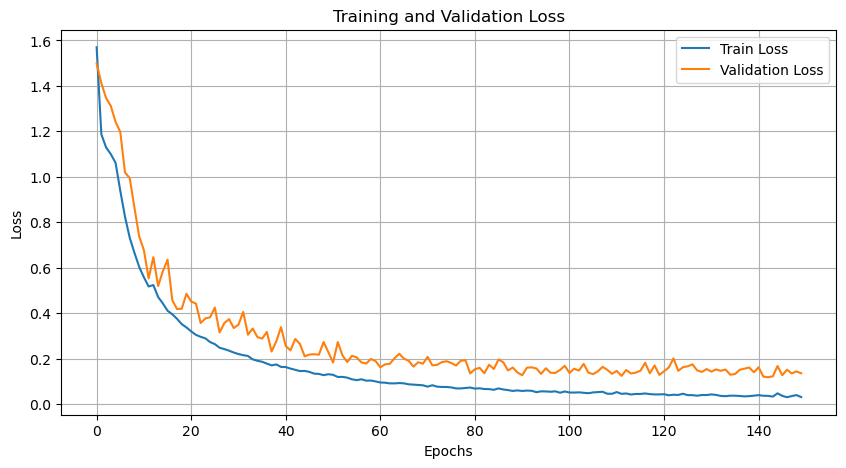

Accuracy: 0.9637

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.57      0.84      0.68       556
           2       0.87      0.96      0.91      1448
           3       0.61      0.88      0.72       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.81      0.92      0.86     21892
weighted avg       0.97      0.96      0.97     21892



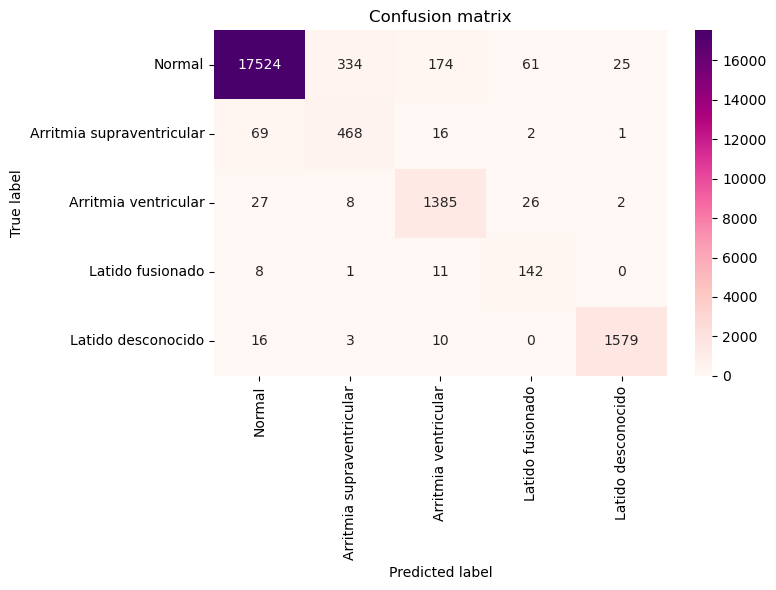

In [ ]:
model_gru_1 = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=False).to(DEVICE)
gru_1_train_errors, gru_1_val_errors = run_rnn_model(use_sampler=True, model=model_gru_1)

### GRU + transform (z-score and augmentation)

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.17077 | Val Loss: 0.27768
Epoch: 040/120 | Train Loss: 0.09613 | Val Loss: 0.20835
Epoch: 060/120 | Train Loss: 0.07411 | Val Loss: 0.16689
Epoch: 080/120 | Train Loss: 0.05482 | Val Loss: 0.16091
Epoch: 100/120 | Train Loss: 0.05165 | Val Loss: 0.14236
Epoch: 120/120 | Train Loss: 0.03944 | Val Loss: 0.14293


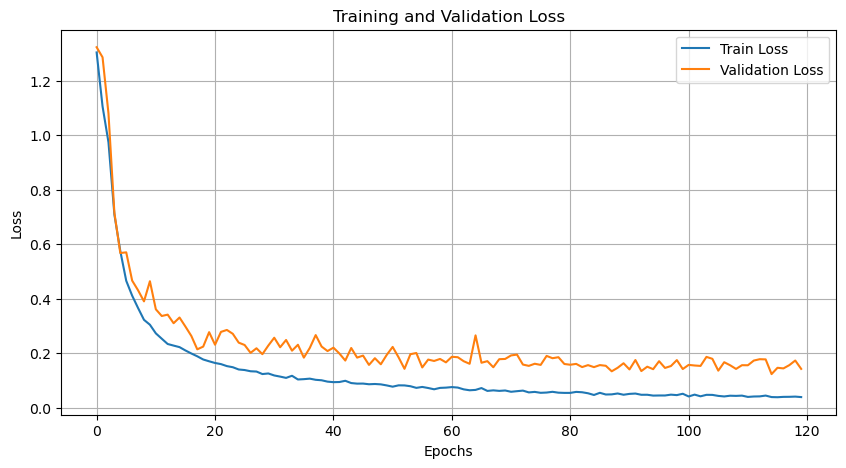

Accuracy: 0.9616

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     18118
           1       0.52      0.84      0.64       556
           2       0.89      0.96      0.92      1448
           3       0.61      0.88      0.72       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.80      0.92      0.85     21892
weighted avg       0.97      0.96      0.96     21892



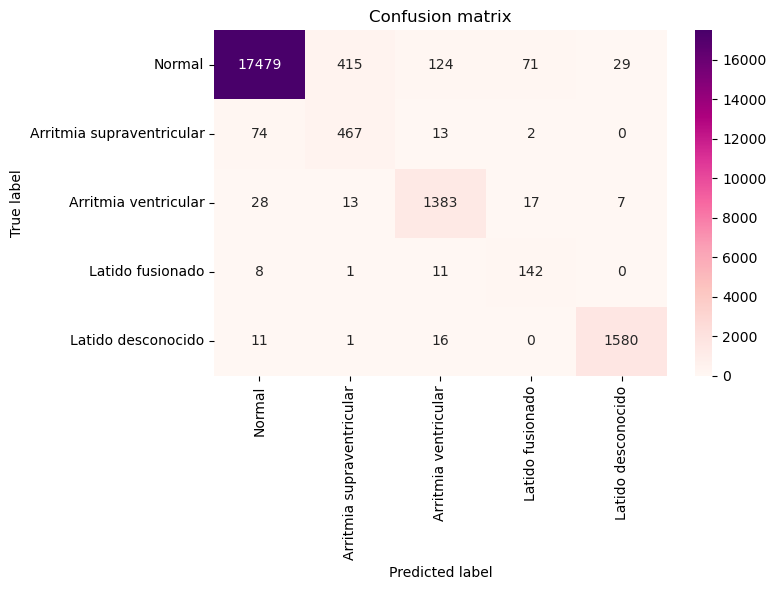

In [ ]:
model_gru_2 = GRU().to(DEVICE)
gru_2_train_errors, gru_2_val_errors = run_rnn_model(use_zscore=True, use_augmentation=True, model=model_gru_2)

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.06646 | Val Loss: 0.84931
Epoch: 040/120 | Train Loss: 0.03292 | Val Loss: 0.69052
Epoch: 060/120 | Train Loss: 0.03320 | Val Loss: 0.54102
Epoch: 080/120 | Train Loss: 0.02661 | Val Loss: 0.56700
Epoch: 100/120 | Train Loss: 0.01734 | Val Loss: 0.49637
Epoch: 120/120 | Train Loss: 0.01507 | Val Loss: 0.54850


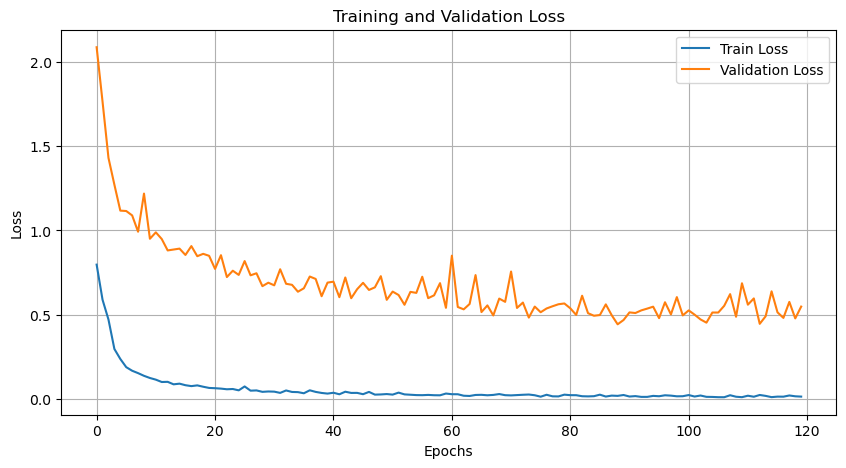

Accuracy: 0.7883

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86     18118
           1       0.14      0.93      0.25       556
           2       0.65      0.97      0.77      1448
           3       0.21      0.92      0.34       162
           4       0.89      0.98      0.93      1608

    accuracy                           0.79     21892
   macro avg       0.58      0.91      0.63     21892
weighted avg       0.94      0.79      0.84     21892



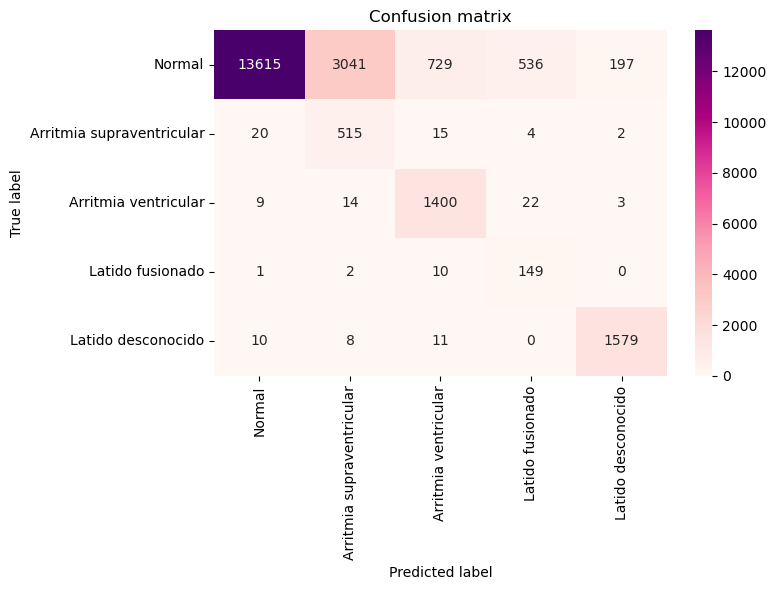

In [ ]:
# TODO borrar esta prueba
model_gru_3 = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=False).to(DEVICE)

gru_3_train_errors, gru_3_val_errors = run_rnn_model(
    use_zscore=True,
    use_augmentation=True,
    use_sampler=True,
    use_class_weights=True,
    model=model_gru_3
)

### GRU Bidireccional

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.05779 | Val Loss: 0.05348
Epoch: 040/120 | Train Loss: 0.03252 | Val Loss: 0.04757
Epoch: 060/120 | Train Loss: 0.02248 | Val Loss: 0.04635
Epoch: 080/120 | Train Loss: 0.01682 | Val Loss: 0.05228
Epoch: 100/120 | Train Loss: 0.01473 | Val Loss: 0.05486
Epoch: 120/120 | Train Loss: 0.01353 | Val Loss: 0.05732


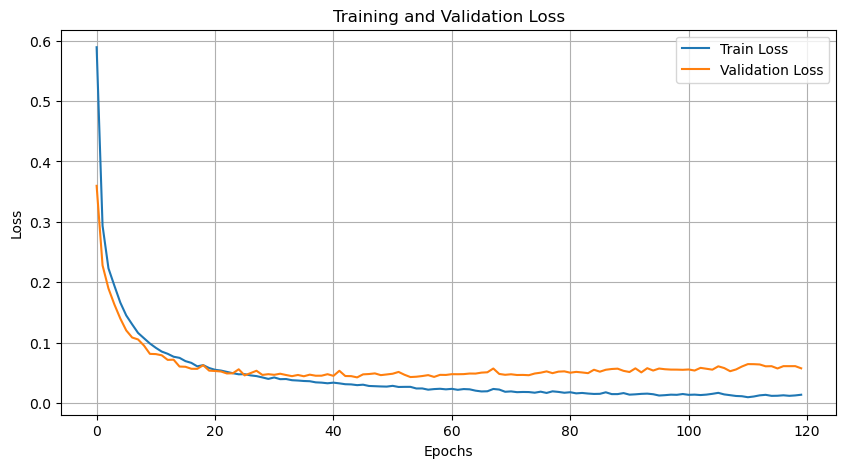

Accuracy: 0.9863

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.90      0.83      0.86       556
           2       0.96      0.96      0.96      1448
           3       0.87      0.76      0.81       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.91      0.92     21892
weighted avg       0.99      0.99      0.99     21892



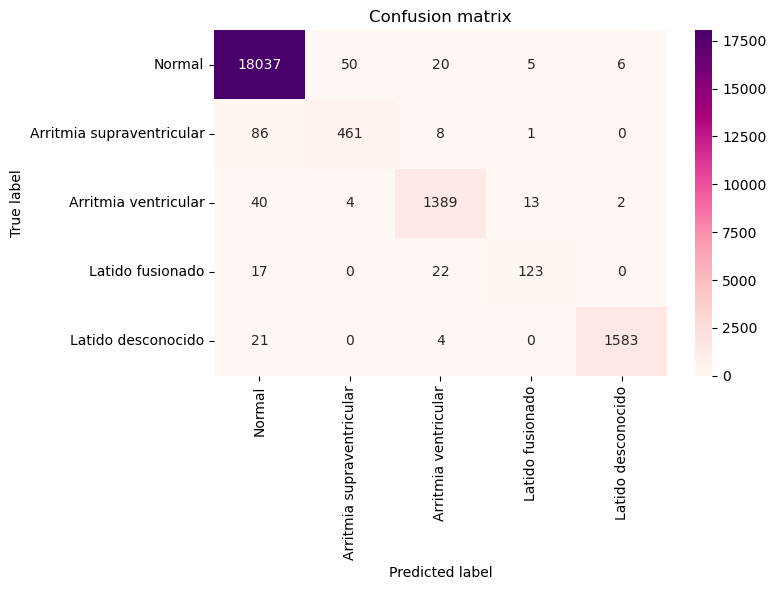

In [ ]:
model_gru_4 = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=True).to(DEVICE)

gru_4_train_errors, gru_4_val_errors = run_rnn_model(model=model_gru_4, bidirectional=True)

### GRU Bidireccional + early stopping

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.06652 | Val Loss: 0.06611
Epoch: 040/120 | Train Loss: 0.03862 | Val Loss: 0.04700
Epoch: 060/120 | Train Loss: 0.02685 | Val Loss: 0.04924
Detener entrenamiento en la época 69, la mejor pérdida fue 0.04438


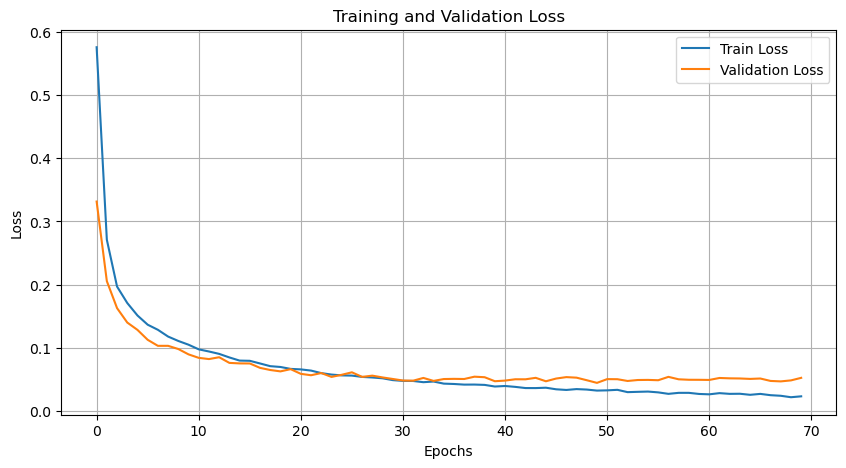

Accuracy: 0.9848

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.90      0.80      0.85       556
           2       0.95      0.96      0.96      1448
           3       0.89      0.72      0.79       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.94      0.89      0.92     21892
weighted avg       0.98      0.98      0.98     21892



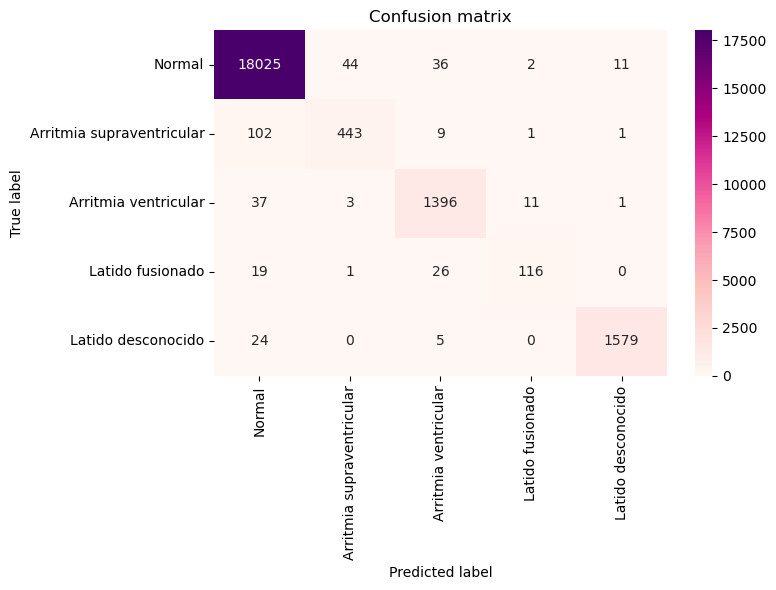

In [ ]:
model_gru_5 = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=True).to(DEVICE)

gru_5_train_errors, gru_5_val_errors = run_rnn_model(early_stopping=True, model=model_gru_5, bidirectional=True)

### GRU Bidireccional + early stopping + Z-score

Running: gru
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.04864 | Val Loss: 0.05320
Epoch: 040/120 | Train Loss: 0.02839 | Val Loss: 0.04761
Epoch: 060/120 | Train Loss: 0.02072 | Val Loss: 0.05025
Detener entrenamiento en la época 59, la mejor pérdida fue 0.04313


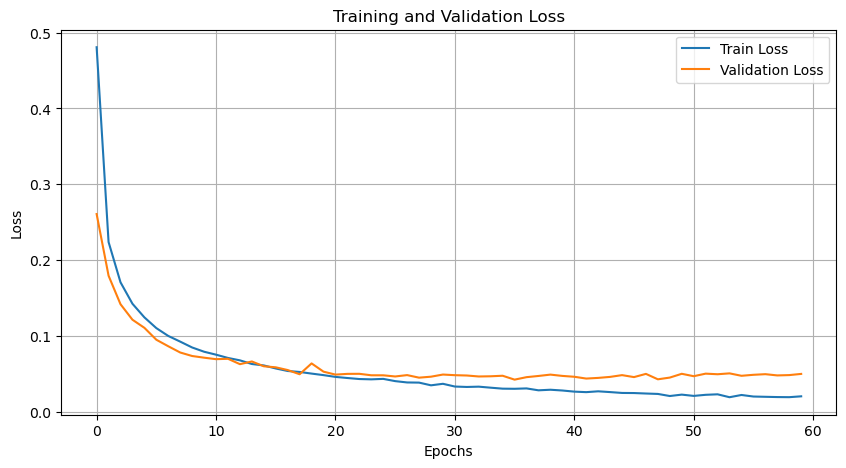

Accuracy: 0.9863

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.90      0.80      0.84       556
           2       0.96      0.96      0.96      1448
           3       0.84      0.84      0.84       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.92      0.93     21892
weighted avg       0.99      0.99      0.99     21892



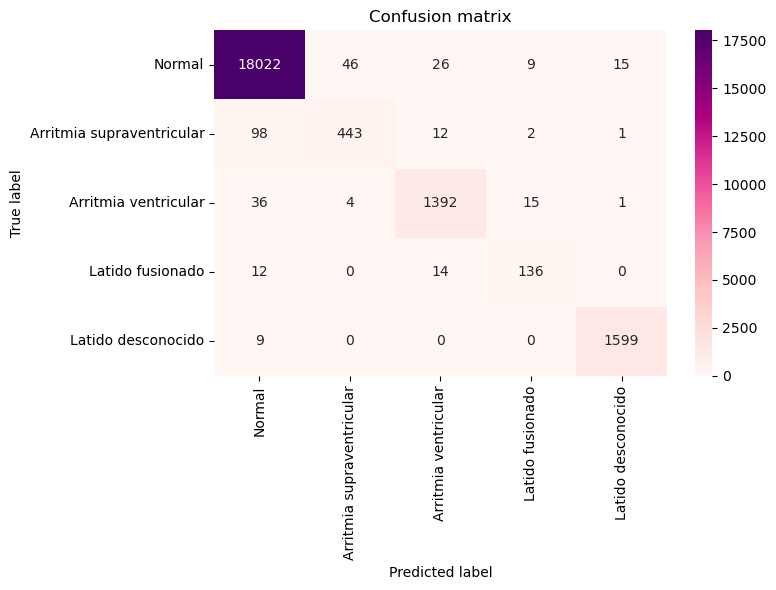

In [ ]:
model_gru_6 = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=True).to(DEVICE)

gru_6_train_errors, gru_6_val_errors = run_rnn_model(use_zscore=True, early_stopping=True, model=model_gru_6, bidirectional=True)

## Training LSTM

Running: LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 0.57971 | Val Loss: 0.54433
Epoch: 040/120 | Train Loss: 0.33318 | Val Loss: 0.30254
Epoch: 060/120 | Train Loss: 0.22854 | Val Loss: 0.20708
Epoch: 080/120 | Train Loss: 0.14323 | Val Loss: 0.14428
Epoch: 100/120 | Train Loss: 0.11879 | Val Loss: 0.11409
Epoch: 120/120 | Train Loss: 0.10114 | Val Loss: 0.11926


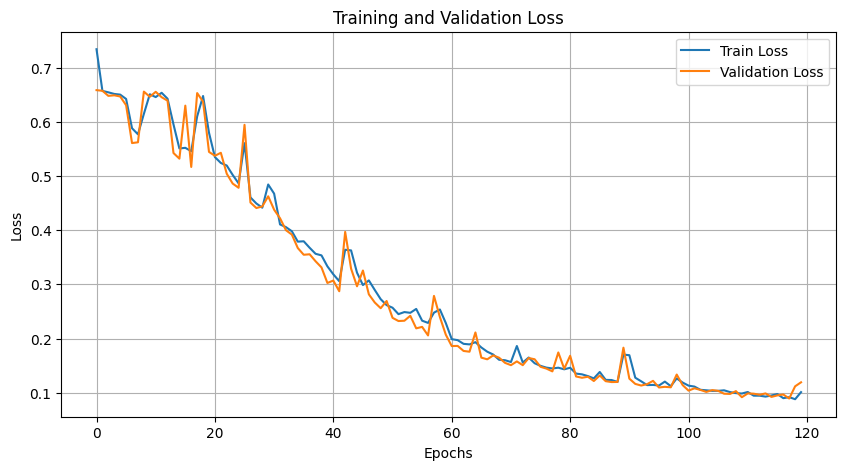

Accuracy: 0.9646

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18118
           1       0.93      0.55      0.69       556
           2       0.93      0.87      0.90      1448
           3       0.74      0.42      0.54       162
           4       0.94      0.92      0.93      1608

    accuracy                           0.96     21892
   macro avg       0.90      0.75      0.81     21892
weighted avg       0.96      0.96      0.96     21892



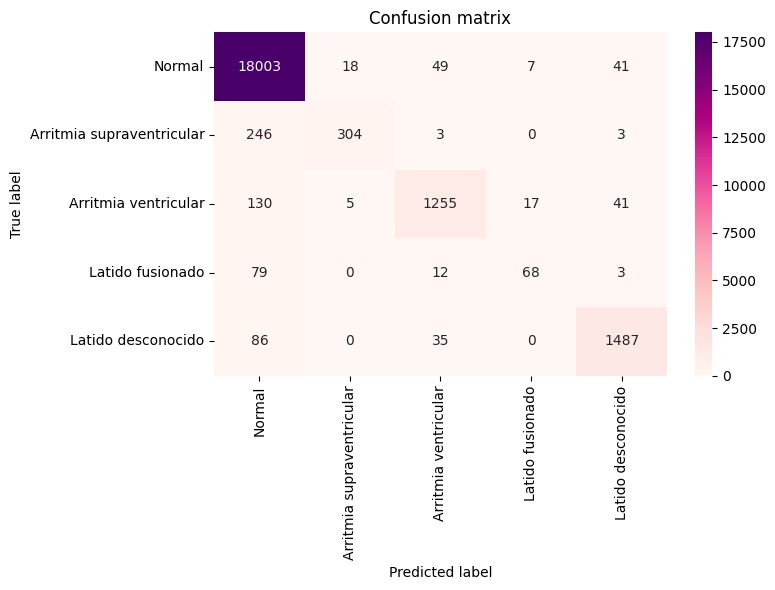

In [ ]:
lstm_model_0 = LSTMModel(input_dim=1, hidden_dim=64, n_layers=1, num_classes=5).to(DEVICE)
lstm_0_train_errors, lstm_0_val_errors = run_rnn_model(model=lstm_model_0)

### LSTM bidireccional

Running: LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch: 020/120 | Train Loss: 0.12576 | Val Loss: 0.12199
Epoch: 040/120 | Train Loss: 0.07187 | Val Loss: 0.07070
Epoch: 060/120 | Train Loss: 0.04980 | Val Loss: 0.06193
Epoch: 080/120 | Train Loss: 0.03898 | Val Loss: 0.06305
Epoch: 100/120 | Train Loss: 0.03178 | Val Loss: 0.05183
Epoch: 120/120 | Train Loss: 0.02558 | Val Loss: 0.05585


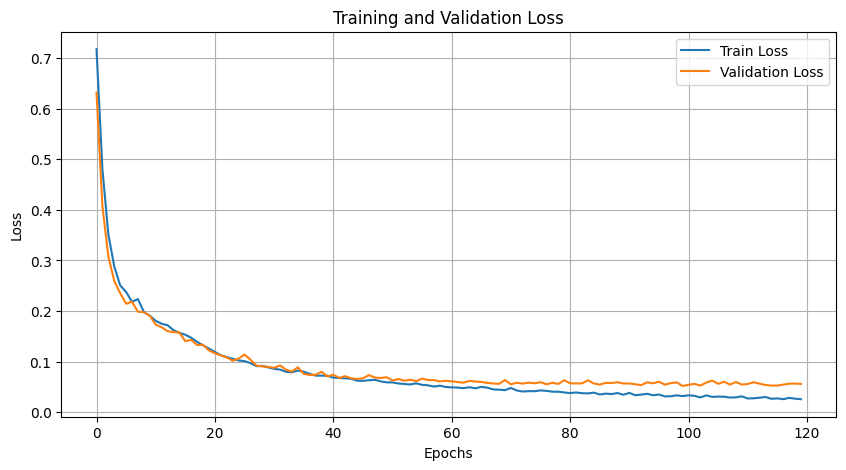

Accuracy: 0.9836

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.88      0.77      0.82       556
           2       0.96      0.96      0.96      1448
           3       0.81      0.80      0.81       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.93      0.90      0.91     21892
weighted avg       0.98      0.98      0.98     21892



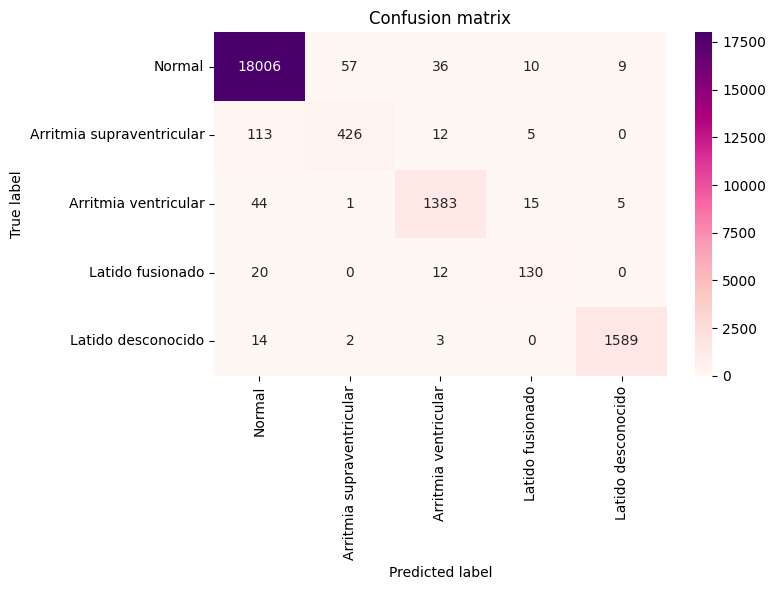

In [ ]:
lstm_model_1 = LSTMModel(input_dim=1, hidden_dim=64, n_layers=1, num_classes=5, bidirectional=True).to(DEVICE)
lstm_1_train_errors, lstm_1_val_errors = run_rnn_model(model=lstm_model_1)

### LSTM bidireccional + Z-score

In [ ]:
lstm_model_z = LSTMModel(bidirectional=True).to(DEVICE)
lstm_z_train_errors, lstm_z_val_errors = run_rnn_model(use_zscore=True, model=lstm_model_z)

### LSTM bidireccional + packing

Running: LSTMModel_packing(
  (lstm): LSTM(1, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch: 020/120 | Train Loss: 0.11643 | Val Loss: 0.22218
Epoch: 040/120 | Train Loss: 0.05972 | Val Loss: 0.14963
Epoch: 060/120 | Train Loss: 0.06841 | Val Loss: 0.12405
Epoch: 080/120 | Train Loss: 0.03051 | Val Loss: 0.11235
Epoch: 100/120 | Train Loss: 0.02202 | Val Loss: 0.10296
Epoch: 120/120 | Train Loss: 0.01441 | Val Loss: 0.08688


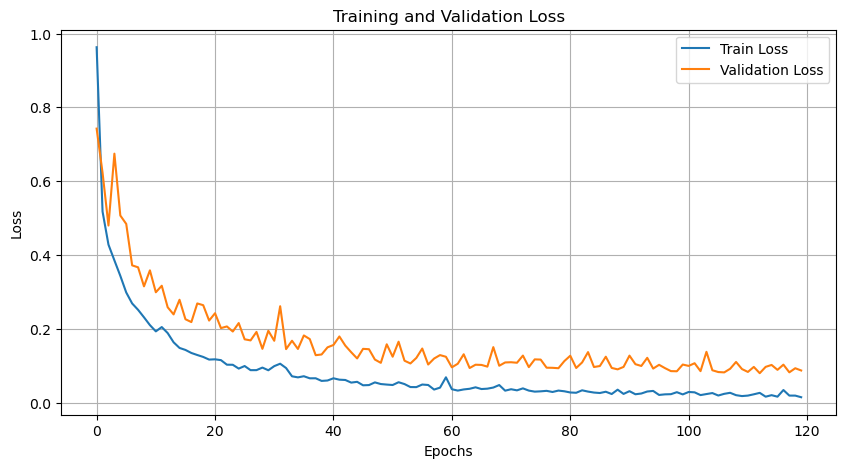

Accuracy: 0.9751

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.72      0.82      0.77       556
           2       0.92      0.94      0.93      1448
           3       0.66      0.83      0.74       162
           4       0.98      0.99      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.86      0.91      0.88     21892
weighted avg       0.98      0.98      0.98     21892



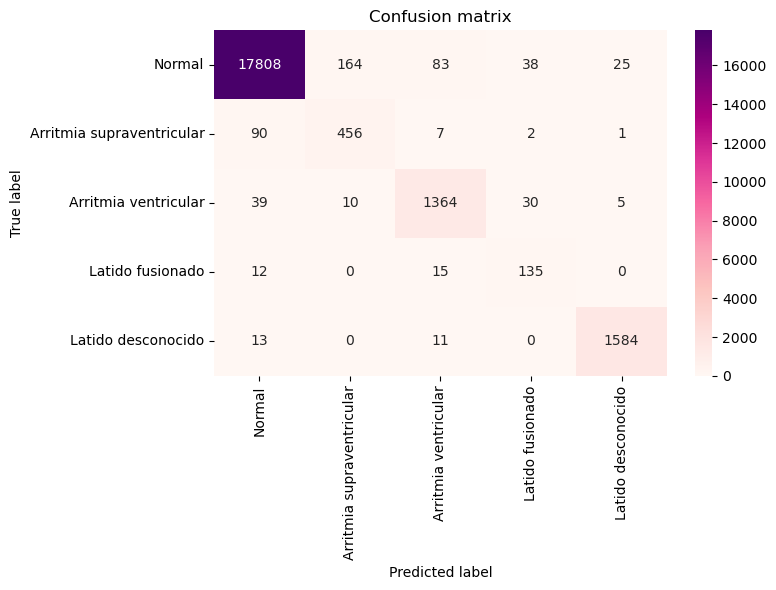

In [59]:
lstm_2_model = LSTMModel_packing(input_dim=1, hidden_dim=64, n_layers=1, num_classes=5, bidirectional=True).to(DEVICE)
lstm_2_train_errors, lstm_2_val_errors = run_rnn_model(
    use_zscore=True, use_augmentation=True, use_sampler=True, packing=True, model=lstm_2_model
)

# Por qué funciona mal la RNN simple?

## Vanishing gradients

Una forma en la que podemos verificar si nuestra RNN está teniendo gradientes muy chicos es ver cómo evolucionan los pesos durante el entrenamiento: si los pesos varían poco, es porque el gradiente es chico.

In [ ]:
from collections import defaultdict

def train_vg(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=print_log,
    log_every=1,
    track_grads=False,              # registrar gradientes
    grad_reduce="mean",             # "mean" o "median" para agregar por época
):
    """
    Entrena el modelo y (opcional) registra magnitudes de gradiente para detectar vanishing gradients.
    """
    epoch_train_errors = []
    epoch_val_errors = []
    if do_early_stopping:
        early_stopping = EarlyStopping(patience=patience)

    # Estructuras para gradientes
    if track_grads:
        # Guardamos por época: global, recurrentes, input, por-parámetro
        grad_history = {
            "global": [],
            "recurrent": [],
            "input": [],
            "by_param": defaultdict(list),  # dict: nombre_param -> lista por época
        }
        # Acumuladores por época (se reinician cada época)
        def _new_epoch_acc():
            return {
                "global": [],
                "recurrent": [],
                "input": [],
                "by_param": defaultdict(list),
            }
        epoch_acc = _new_epoch_acc()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            output = model(x)
            batch_loss = criterion(output, y)
            batch_loss.backward()

            # ===== Registro de gradientes por lote =====
            if track_grads:
                # Normas L2 por parámetro con gradiente
                grads = [(n, p.grad.detach()) for n, p in model.named_parameters() if p.grad is not None]
                if grads:
                    # Norma global de todos los gradientes
                    global_norm = torch.norm(torch.stack([g.norm(2) for _, g in grads]), p=2).item()
                    epoch_acc["global"].append(global_norm)

                    # Separar pesos recurrentes vs de entrada (nombres estándar PyTorch: weight_hh*, weight_ih*)
                    rec = [g for n, g in grads if "weight_hh" in n or "recurrent" in n or "rnn" in n and "weight" in n]
                    inp = [g for n, g in grads if "weight_ih" in n or ("embedding" in n and "weight" in n)]
                    if rec:
                        epoch_acc["recurrent"].append(torch.mean(torch.stack([g.abs().mean() for g in rec])).item())
                    if inp:
                        epoch_acc["input"].append(torch.mean(torch.stack([g.abs().mean() for g in inp])).item())

                    # Guardar por parámetro (media absoluta para robustez)
                    for n, g in grads:
                        epoch_acc["by_param"][n].append(g.abs().mean().item())

            optimizer.step()
            train_loss += batch_loss.item()

        train_loss /= len(train_loader)
        epoch_train_errors.append(train_loss)

        val_loss = evaluate(model, criterion, val_loader, device)
        epoch_val_errors.append(val_loss)

        if do_early_stopping:
            early_stopping(val_loss)

        if log_fn is not None and ((epoch + 1) % log_every == 0):
            log_fn(epoch, train_loss, val_loss, epochs)

        # ===== Cierre de época: agregar gradientes =====
        if track_grads:
            import numpy as np
            reducer = np.mean if grad_reduce == "mean" else np.median

            # Global, recurrent, input
            grad_history["global"].append(reducer(epoch_acc["global"]) if epoch_acc["global"] else float("nan"))
            grad_history["recurrent"].append(reducer(epoch_acc["recurrent"]) if epoch_acc["recurrent"] else float("nan"))
            grad_history["input"].append(reducer(epoch_acc["input"]) if epoch_acc["input"] else float("nan"))

            # Por parámetro
            for name, series in epoch_acc["by_param"].items():
                grad_history["by_param"][name].append(reducer(series))
            # Asegurar que parámetros sin grad este epoch reciban NaN para mantener longitudes
            all_param_names = [n for n, _ in model.named_parameters()]
            for n in all_param_names:
                if n not in grad_history["by_param"]:
                    grad_history["by_param"][n] = [float("nan")] * (epoch + 1)
                elif len(grad_history["by_param"][n]) < (epoch + 1):
                    grad_history["by_param"][n].append(float("nan"))

            # Reset acumuladores para la próxima época
            epoch_acc = _new_epoch_acc()

        if do_early_stopping and early_stopping.early_stop:
            print(f"Detener entrenamiento en la época {epoch}, la mejor pérdida fue {early_stopping.best_score:.5f}")
            break

    # Salida estándar
    if track_grads:
        return epoch_train_errors, epoch_val_errors, grad_history
    return epoch_train_errors, epoch_val_errors


In [ ]:
def run_rnn_model_vg(
    use_zscore=False,
    use_augmentation=False,
    use_sampler=False,
    use_class_weights=False,
    early_stopping=False,
    model='rnn',
    bidirectional=False
):

    train_transf = lambda x: train_transform_np(x, use_zscore=use_zscore, use_augmentation=use_augmentation)
    val_transf   = lambda x: eval_transform_np(x,  use_zscore=use_zscore)

    train_loader, val_loader, test_loader = get_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        train_transf=train_transf,
        val_transf=val_transf,
        use_sampler=use_sampler  # True => balancea batches por muestreo
    )

    print(f"Running: {model}")
    if model == 'rnn':
        model = SimpleRNN(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5).to(DEVICE)
    #elif model == 'gru':
    #    model = GRU(input_dim=1, hidden_dim=64, n_layers=2, num_classes=5, bidirectional=bidirectional).to(DEVICE)
    #else:
    #    raise ValueError(f"Modelo {model} no soportado")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # si usamos use_class_weights entonces se balancea por class weights
    if use_class_weights:
        class_weights = compute_class_weights(y_train, n_classes=5).to(DEVICE)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()


    # Chequeo rápido
    #xb, yb = next(iter(train_loader))
    #print("Batch:", xb.shape, yb.shape)  # esperado: [B,187,1]  [B]

    epoch_train_errors, epoch_val_errors, grad_history = train_vg(
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        DEVICE,
        do_early_stopping=early_stopping,
        patience=12,
        epochs=EPOCHS,
        log_every=20,
        track_grads=True,
        grad_reduce="mean"
    )

    plot_training(epoch_train_errors, epoch_val_errors)

    model_classification_report(model, test_loader, DEVICE, nclasses, do_confusion_matrix=True)

    return epoch_train_errors, epoch_val_errors, grad_history


Running: rnn
Batch: torch.Size([256, 187, 1]) torch.Size([256])
Epoch: 020/120 | Train Loss: 1.21340 | Val Loss: 1.41256
Epoch: 040/120 | Train Loss: 1.03540 | Val Loss: 1.38623
Epoch: 060/120 | Train Loss: 1.27718 | Val Loss: 1.35351
Epoch: 080/120 | Train Loss: 0.94448 | Val Loss: 1.28041
Epoch: 100/120 | Train Loss: 0.90584 | Val Loss: 1.17790
Epoch: 120/120 | Train Loss: 1.26543 | Val Loss: 1.43262


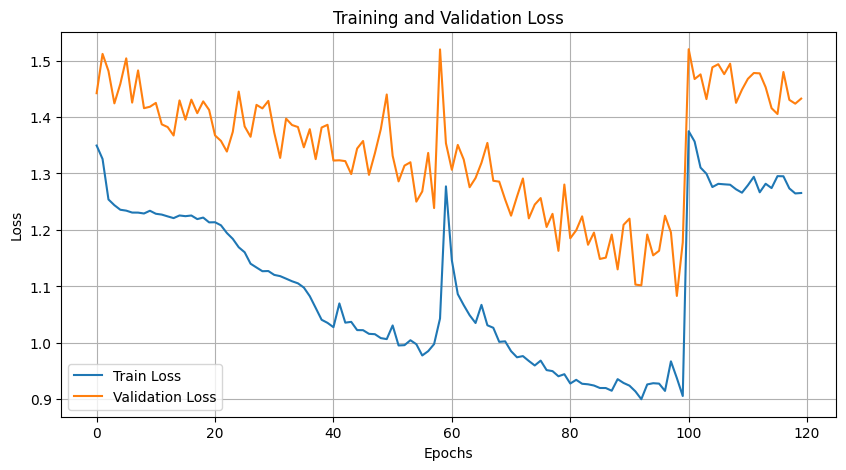

Accuracy: 0.3216

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.30      0.45     18118
           1       0.07      0.50      0.13       556
           2       0.14      0.16      0.14      1448
           3       0.02      0.88      0.04       162
           4       0.34      0.62      0.44      1608

    accuracy                           0.32     21892
   macro avg       0.29      0.49      0.24     21892
weighted avg       0.78      0.32      0.42     21892



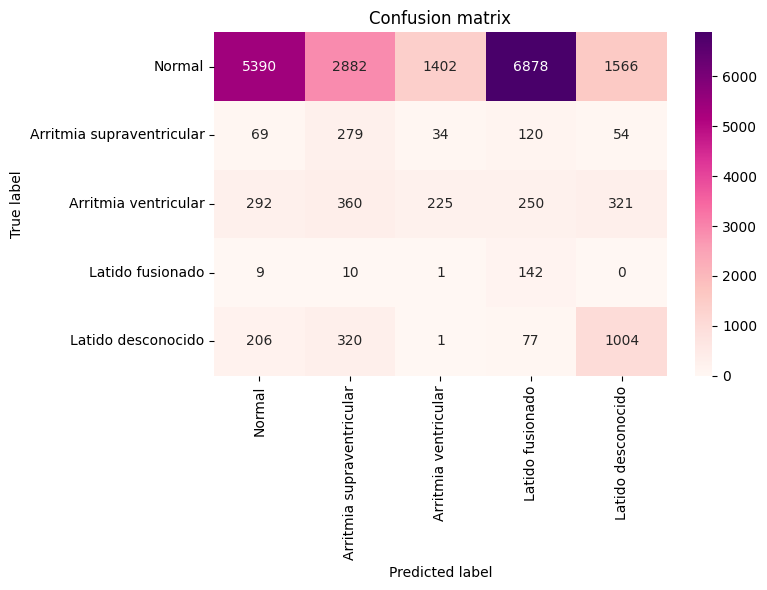

In [ ]:
rnn_vg_train_errors, rnn_vg_val_errors, rnn_vg_grad_history = run_rnn_model_vg(use_zscore=True, use_augmentation=True, use_sampler=True)

In [ ]:
def plot_gradients(grad_history):
    epochs = range(1, len(grad_history["global"]) + 1)

    plt.figure()
    plt.plot(epochs, grad_history["global"], label="Global", linewidth=1.5)
    plt.plot(epochs, grad_history["recurrent"], label="Recurrente", linewidth=1.5)
    plt.plot(epochs, grad_history["input"], label="Input", linewidth=1.5)
    plt.yscale("log")  # log para ver rangos pequeños
    plt.xlabel("Época")
    plt.ylabel("Magnitud media del gradiente (escala log)")
    plt.title("Evolución de gradientes")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.show()

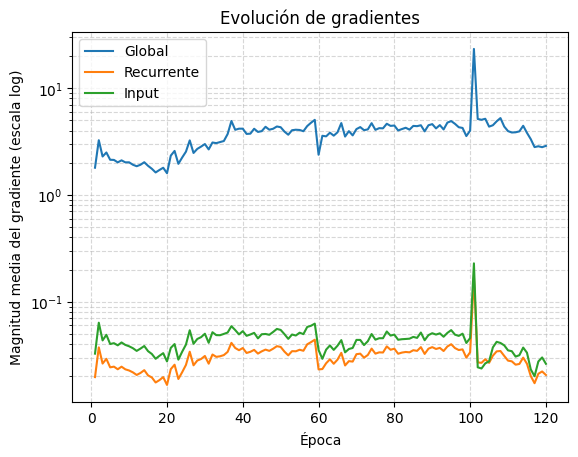

In [ ]:
plot_gradients(rnn_vg_grad_history)

La gráfica anterior se obtuvo calculando la magnitud de los graadientes de los parámetros del modelo.

*Global = todos los gradientes del modelo combinados.*

*Recurrente = pesos internos de la parte recurrente de la RNN (los whh).*

*Input = gradientes del input como referencia*

Podemos ver que los gradientes no se van a cero pero sí llegan a valores muy chicos (gráfica naranja), lo que puede llevar a que la red no aprenda bien las primeras partes de la secuencia que recibe.

## Secuencias con muchos ceros al final

Otra posible razón por la que la RNN obtiene malos resultados es que la mayoría de las secuencias termina con un promedio de 75 ceros. Como la RNN procesa los datos en orden, al llegar al final solo dispone de estos ceros como información. Además, al no tener memoria a largo plazo, esta información final predomina sobre la inicial y termina generando un mal desempeño.

# Weight and Biases

In [72]:
import wandb
WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea2"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_2-letra.ipynb"

wandb.login()

True

In [128]:
sweep_config_gru = {
    "name": "Tarea_2_GRU",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},
    "parameters": {
        # Optimizador y LR
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},

        # Entrenamiento
        "label_smoothing": {"values": [0.0, 0.05]},
         "weight_decay": {"values": [1e-4]},

        # Modelo
        "model"  : {"values": ["gru"]},
        "hidden_dim": {"values": [128, 256]},
        "n_layers": {"values": [1, 3, 5]},
    },
}

sweep_id_gru = wandb.sweep(sweep_config_gru, project=WANDB_PROJECT)

Create sweep with ID: w4n41lf2
Sweep URL: https://wandb.ai/campiglianatalia-ort/Tarea2/sweeps/w4n41lf2


In [129]:
sweep_config_lstm = {
    "name": "Tarea_2_LSTM",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},
    "parameters": {
         # Modelo
        "model"  : {"values": ["lstm"]},

        # Optimizador y LR
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [1e-4]},

        # Entrenamiento
        "label_smoothing": {"values": [0.0, 0.05]},
        "hidden_dim": {"values": [128, 256]},
        "n_layers": {"values": [1, 3, 5]},
    },
}

sweep_id_lstm = wandb.sweep(sweep_config_lstm, project=WANDB_PROJECT)

Create sweep with ID: 84t97bj7
Sweep URL: https://wandb.ai/campiglianatalia-ort/Tarea2/sweeps/84t97bj7


In [130]:
entity = wandb.api.default_entity
project = WANDB_PROJECT

In [131]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
supports = []

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_label_smoothing = config.label_smoothing
    run_model = config.model
    weight_decay = config.weight_decay

    hidden_dim = config.hidden_dim
    n_layers = config.n_layers


    # model
    if run_model == "gru":
        model = GRU(input_dim=1, hidden_dim=hidden_dim, n_layers=n_layers, num_classes=5, bidirectional=True).to(DEVICE)
    elif run_model == "lstm":
        model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, n_layers=n_layers, num_classes=5, bidirectional=True).to(DEVICE)

    # optimizer
    optimizer =  torch.optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss, epochs=EPOCHS):
        if (epoch + 1) % 10 == 0 or (epoch + 1) == 1:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)


    run_rnn_model(use_zscore=True, early_stopping=True, model=model, log=log_with_timing, optimizer=optimizer, criterion=criterion)


    # guardo pesos temporalmente
    torch.save(model.state_dict(), f"model_{run_model}.pth")
    wandb.save(f"model_{run_model}.pth")

    # Evaluar modelo
    accuracy, precision, recall, f1score, support = model_classification_report(
        model, test_loader, DEVICE, 5, True
    )

    wandb.log({"val_macro_f1": f1score})
    print("\n\n================================================")
    print(f"Macro F1 Score: {accuracy:.4f}")
    print("================================================")

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1score)
    supports.append(support)

    wandb.finish()

## GRU

In [ ]:
wandb.agent(sweep_id_gru, function=sweep_run, count=5)

wandb: Agent Starting Run: 06eb0qxh with config:
wandb: 	hidden_dim: 256
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.000833923736184546
wandb: 	model: gru
wandb: 	n_layers: 3
wandb: 	weight_decay: 0.0001


Running: GRU(
  (gru): GRU(1, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
  (our): Linear(in_features=512, out_features=5, bias=True)
  (relu): ReLU(inplace=True)
  (drop): Dropout(p=0.3, inplace=False)
)


### Mejor modelo

In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
ENTITY = api.default_entity

sweep_gru= api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id_gru}")

# obtenemos el mejor run
best_run_gru = sweep_gru.best_run()

# Obtener summary
print("\n" + "=" * 60)
print(f"SUMMARY of best run: {best_run_gru.name}")
print("=" * 60)

summary = summary_dict(best_run_gru)

for key, value in sorted(summary.items()):
    if not key.startswith('_'):  # excluir campos internos
        print(f"  {key}: {value}")


# descargamos el modelo del mejor run
best_run_gru.file("model_gru.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1



SUMMARY of best run: generous-sweep-2
  epoch: 80
  train_loss: 0.032572921100378474
  val_loss: 0.06044713320021612
  val_macro_f1: 0.908289814918866


<_io.TextIOWrapper name='./model_gru.pth' mode='r' encoding='UTF-8'>

## LSTM

wandb: Agent Starting Run: 646its3t with config:
wandb: 	bidirectional: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00325454963930735
wandb: 	model: lstm
wandb: 	use_augmentation: False
wandb: 	use_class_weights: False
wandb: 	use_sampler: False
wandb: 	use_zscore: False


Running: LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
[EPOCH 20] train_loss=0.0809 val_loss=0.0941
[EPOCH 40] train_loss=0.0504 val_loss=0.0720
[EPOCH 60] train_loss=0.0349 val_loss=0.0681
[EPOCH 80] train_loss=0.0318 val_loss=0.0616
[EPOCH 100] train_loss=0.0255 val_loss=0.0644
Detener entrenamiento en la época 118, la mejor pérdida fue 0.05799


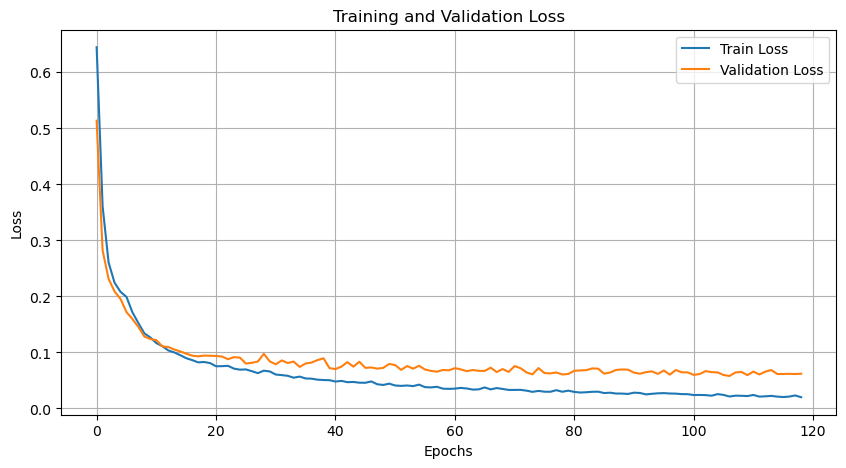

Accuracy: 0.9830

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.91      0.77      0.84       556
           2       0.95      0.96      0.96      1448
           3       0.90      0.64      0.75       162
           4       0.99      0.96      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.95      0.87      0.90     21892
weighted avg       0.98      0.98      0.98     21892



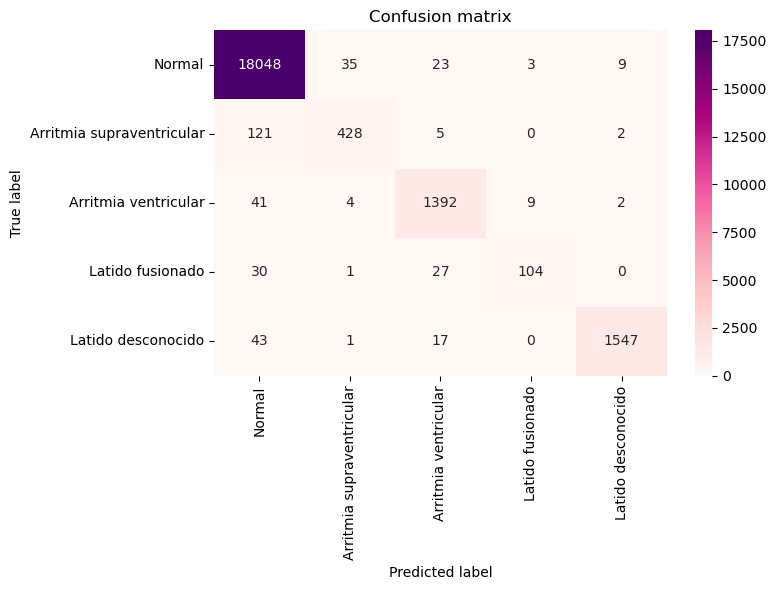

wandb: ERROR The nbformat package was not found. It is required to save notebook history.




Macro F1 Score: 0.9830


epoch,▁▃▅▆█
train_loss,█▄▂▂▁
val_loss,█▃▂▁▂
val_macro_f1,▁
epoch,100
train_loss,0.02545
val_loss,0.06435
val_macro_f1,0.90153


wandb: Agent Starting Run: w7grj5xu with config:
wandb: 	bidirectional: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0011468033874430172
wandb: 	model: lstm
wandb: 	use_augmentation: False
wandb: 	use_class_weights: False
wandb: 	use_sampler: True
wandb: 	use_zscore: False


Running: LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
[EPOCH 20] train_loss=0.1588 val_loss=0.2256
[EPOCH 40] train_loss=0.0604 val_loss=0.1526
Detener entrenamiento en la época 55, la mejor pérdida fue 0.14486


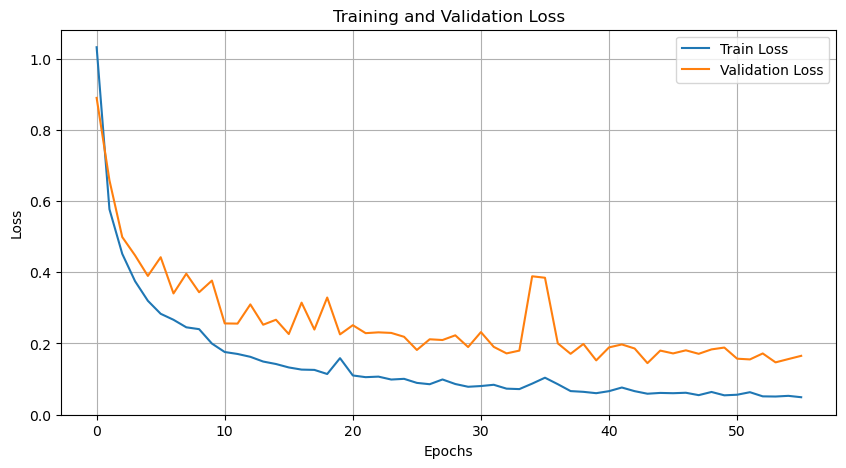

Accuracy: 0.9534

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     18118
           1       0.51      0.87      0.64       556
           2       0.87      0.95      0.91      1448
           3       0.42      0.81      0.55       162
           4       0.97      0.98      0.97      1608

    accuracy                           0.95     21892
   macro avg       0.75      0.91      0.81     21892
weighted avg       0.97      0.95      0.96     21892



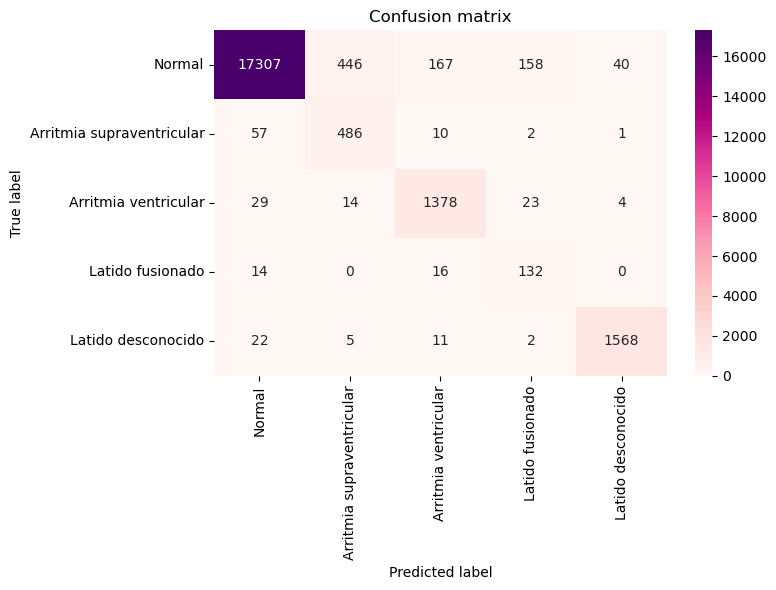

wandb: ERROR The nbformat package was not found. It is required to save notebook history.




Macro F1 Score: 0.9534


epoch,▁█
train_loss,█▁
val_loss,█▁
val_macro_f1,▁
epoch,40
train_loss,0.06045
val_loss,0.15259
val_macro_f1,0.81061


In [ ]:
wandb.agent(sweep_id_lstm, function=sweep_run, count=5)

### Mejor modelo

In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
ENTITY = api.default_entity

sweep_lstm = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id_lstm}")

# obtenemos el mejor run
best_run_lstm = sweep_lstm.best_run()

# Obtener summary
print("\n" + "=" * 60)
print(f"SUMMARY of best run: {best_run_lstm.name}")
print("=" * 60)

summary = summary_dict(best_run_lstm)

for key, value in sorted(summary.items()):
    if not key.startswith('_'):  # excluir campos internos
        print(f"  {key}: {value}")


# descargamos el modelo del mejor run
best_run_lstm.file("model_lstm.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1



SUMMARY of best run: gallant-sweep-5
  epoch: 100
  train_loss: 0.025450559156219455
  val_loss: 0.06435241194549894
  val_macro_f1: 0.9015259739127977


<_io.TextIOWrapper name='./model_lstm.pth' mode='r' encoding='UTF-8'>